In [133]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [81]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


In [82]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [83]:
process_cadastral(df)

In [84]:
df = df.dropna()

In [85]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87728
Tamaño del conjunto de nuevos datos:  15482


In [86]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

## Distancia al centro

In [87]:
center_x = df_modelar['X'].sum()/len(df_modelar['X'])
center_y = df_modelar['Y'].sum()/len(df_modelar['Y'])

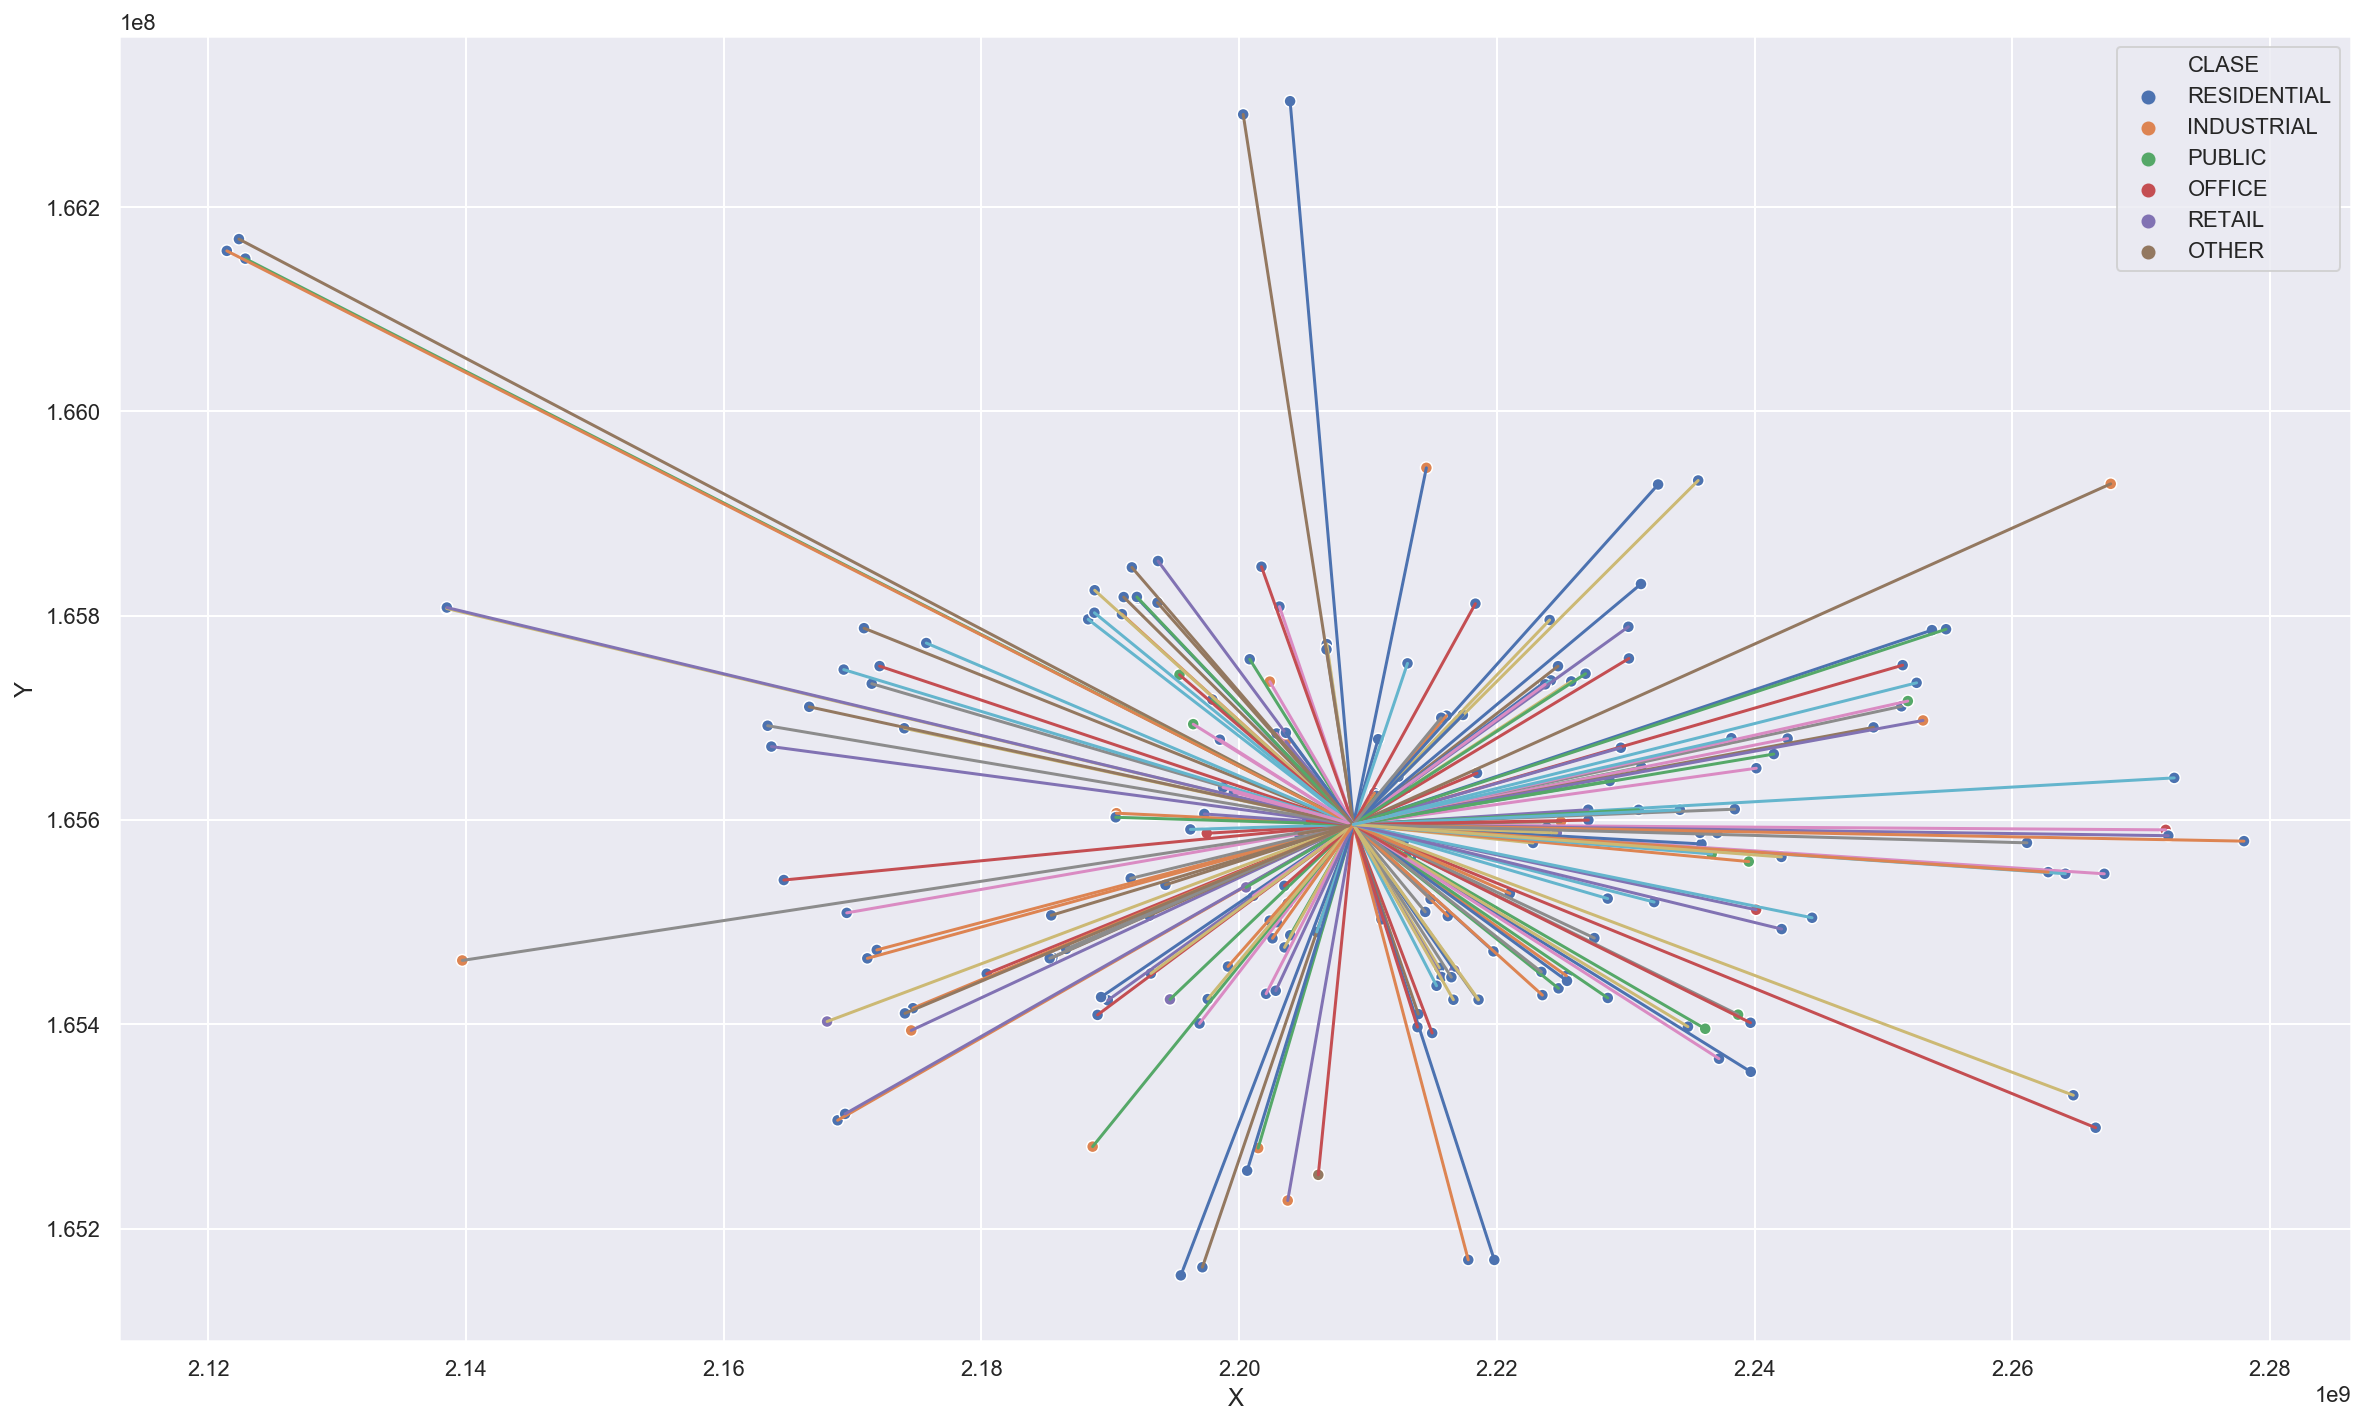

In [88]:
plt.figure(figsize=(20,12))
for i in range(200):
    point1 = [df_modelar.iloc[i]['X'], df_modelar.iloc[i]['Y']]
    point2 = [center_x, center_y]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values)
sns.scatterplot(df_modelar['X'][:200], df_modelar['Y'][:200], hue=df_modelar['CLASE'][:200])

In [89]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [90]:
df_modelar['distance_to_center'] = df_modelar.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)

In [91]:
df_modelar['distance_to_center'] = df_modelar['distance_to_center'] / df_modelar['distance_to_center'].max() #Normalizamos 0,1

In [92]:
df_modelar.groupby('CLASE')['distance_to_center'].mean()

CLASE
AGRICULTURE    0.348430
INDUSTRIAL     0.372862
OFFICE         0.183858
OTHER          0.213616
PUBLIC         0.226200
RESIDENTIAL    0.230438
RETAIL         0.230114
Name: distance_to_center, dtype: float64

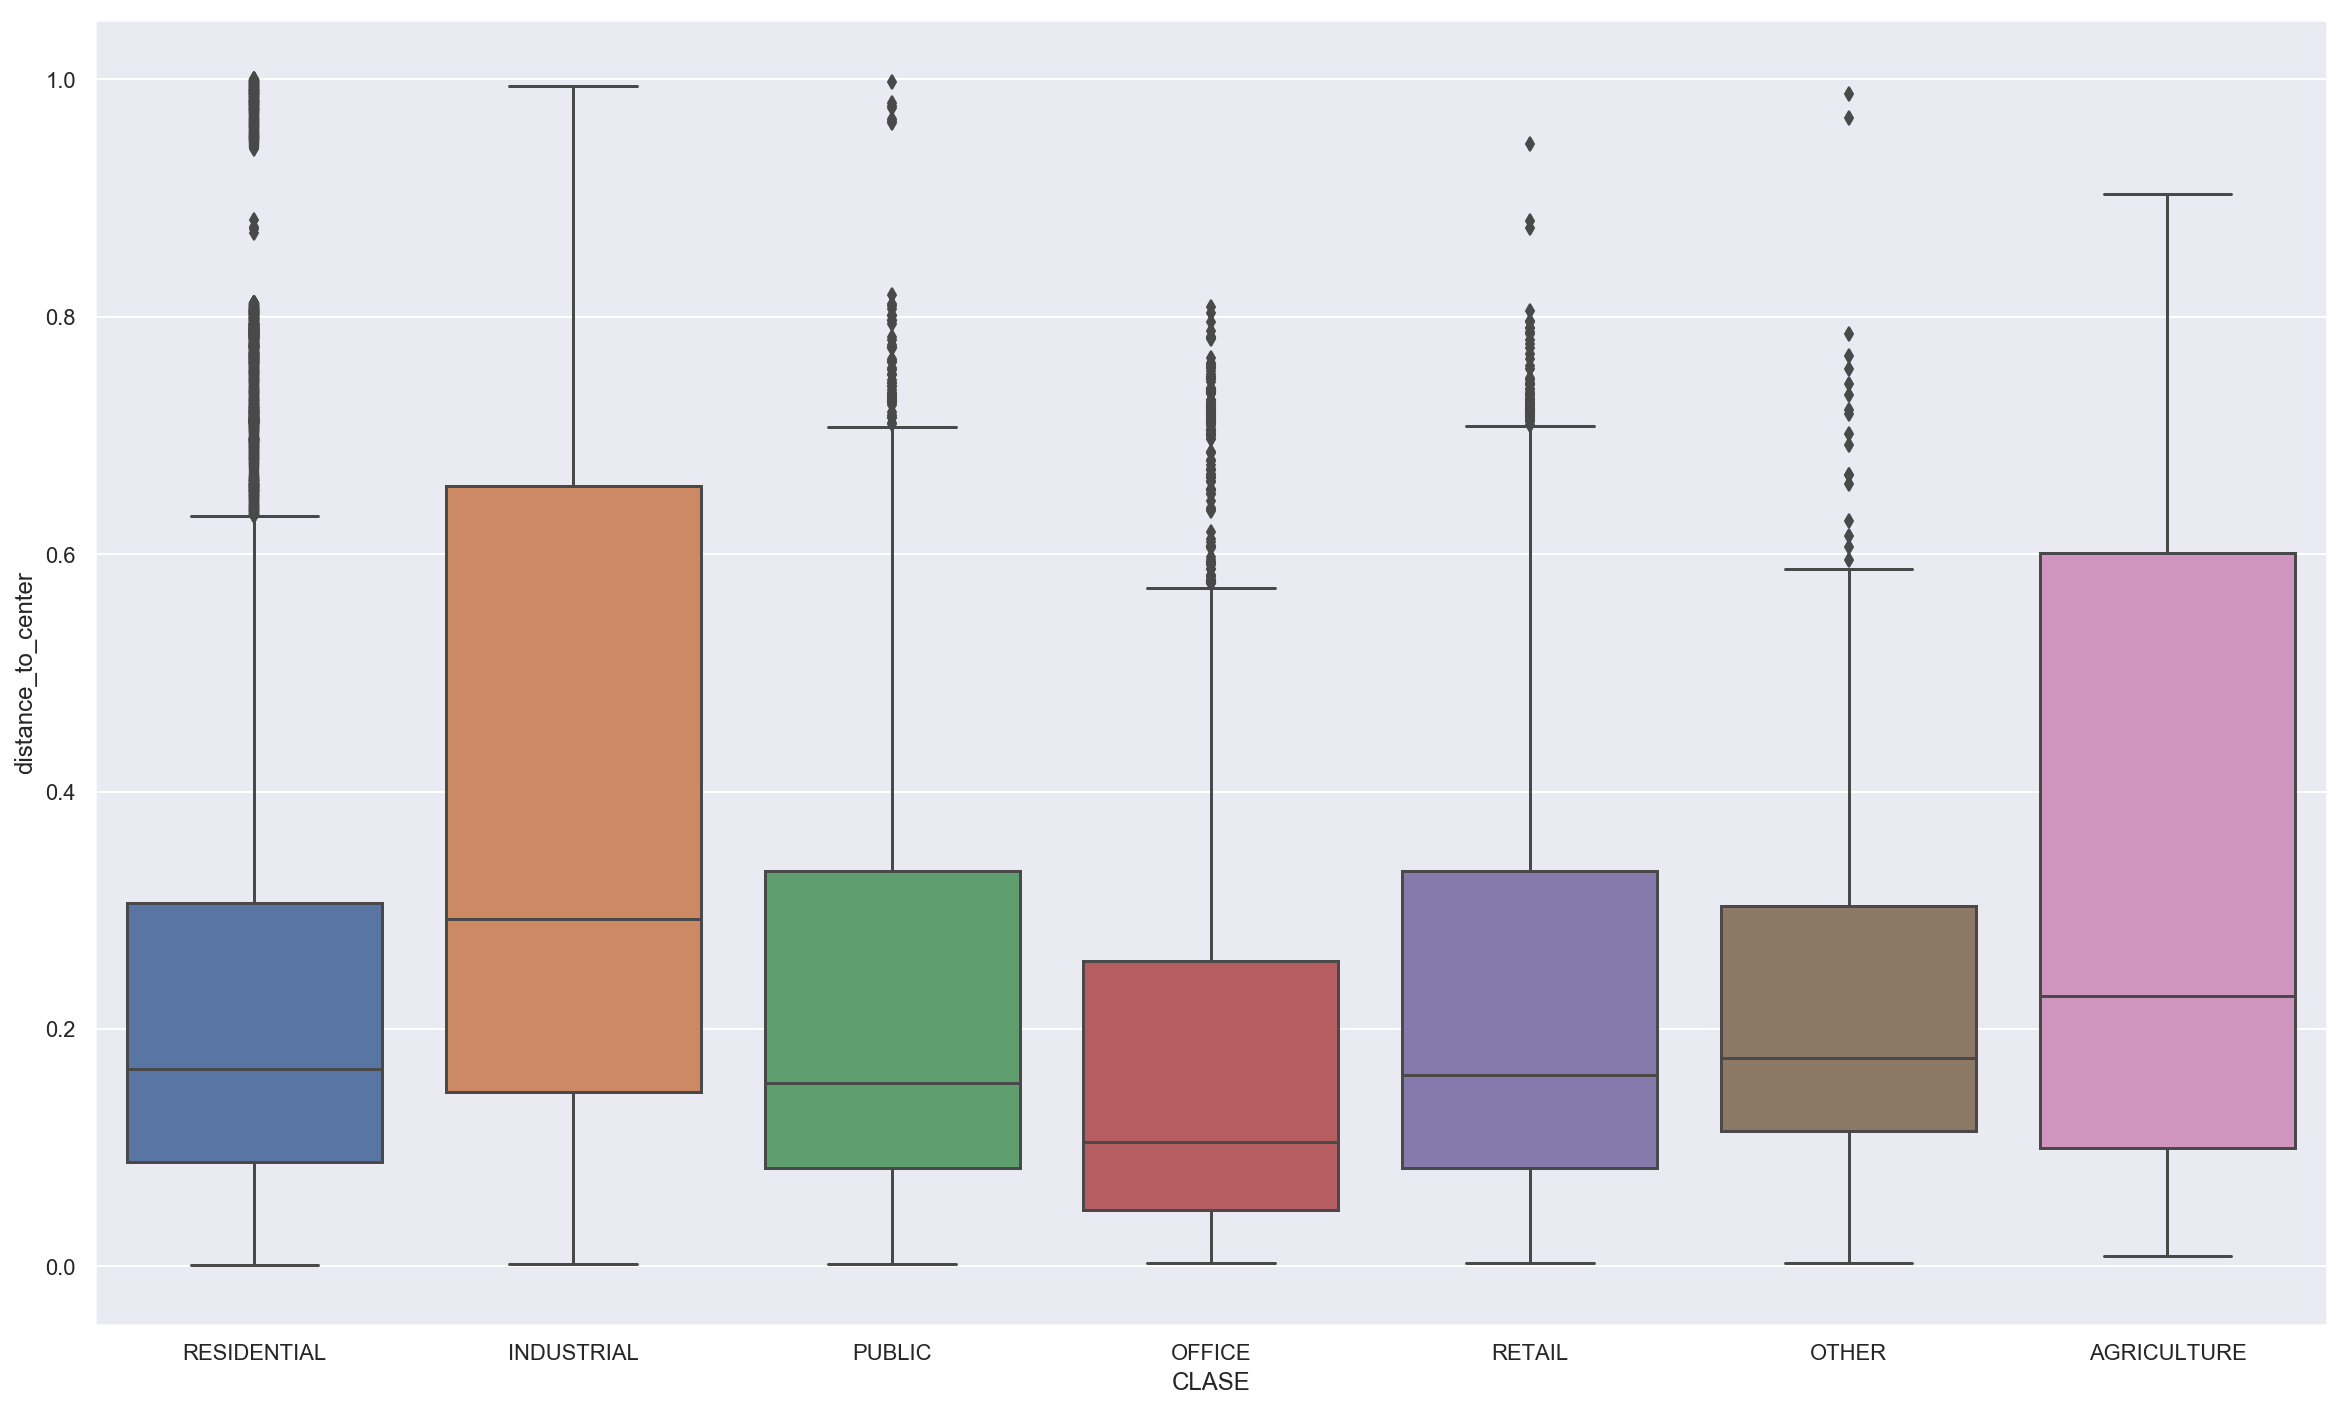

In [93]:
plt.figure(figsize=(20,12))
sns.boxplot(x="CLASE", y="distance_to_center", data=df_modelar)

## Densidad de vecinos

In [94]:
from sklearn.neighbors import KNeighborsClassifier

X = df_modelar[['X', 'Y']].copy()
y = df_modelar['CLASE'].copy()

w = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [124]:
#for n in range(1, 15):
#    neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
#    neigh.fit(X, y)
#    predictKNN = neigh.predict(X_test)
#    w.append(accuracy_score(y_test, predictKNN))             

In [125]:
#plt.figure(figsize=(12,6))
#plt.plot(range(1,15), w)
#plt.xlabel('K-neighbours')
#plt.ylabel('Accuracy');

Como podemos observar si elegiesemos k con valor a 1, estaríamos obteniendo un 1 de accuracy, es decir, no estaríamos fallando en la predicción. Dado que lo que nos interesa es conocer el entorno del registro, no nos vale con un k relativamente pequeño como puede ser 1 o 2. Sin embargo, para poder conocer mejor el entorno del registro a predecir, podemos observar que a partir del valor 5, dejamos de disminuir el accuracy, por lo que creemos que es un valor lo suficientemente representativo del entorno y no sacrificamos demasiado el accuracy. Lo que nos interesa con este proceso no es obtener una clasificación de 1 y no fallar, lo que nos interesa es obtener más registros alrededor de nuestra predicción que nos aporte información con respecto a la situación en la que está. Por ejemplo, si estuviese en el centro la probabilidad de los vecinos a que sean Residenciales serían de 1, mientra que si estuviese a las afueras quizás tendría 2 vecinos residenciales y 3 industriales. Por lo que ello, creemos que le puede aportar mayor información al modelo.

In [95]:
n = 5
neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [96]:
y_pred = neigh.predict(X_test)
y_prob = neigh.predict_proba(X_test)

In [97]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 AGRICULTURE       0.74      0.35      0.48        82
  INDUSTRIAL       0.74      0.51      0.60      1144
      OFFICE       0.54      0.14      0.22       466
       OTHER       0.57      0.06      0.11       340
      PUBLIC       0.60      0.09      0.16       759
 RESIDENTIAL       0.91      0.99      0.95     22995
      RETAIL       0.62      0.07      0.13       533

    accuracy                           0.90     26319
   macro avg       0.67      0.32      0.38     26319
weighted avg       0.87      0.90      0.87     26319



In [98]:
aux = pd.DataFrame(y_prob*n, columns=neigh.classes_, index=X_test.index)

In [99]:
aux_2 = X_test.merge(aux, on='ID', how='inner')

In [100]:
aux_2[neigh.classes_].sum()

AGRICULTURE       245.0
INDUSTRIAL       5238.0
OFFICE           2074.0
OTHER            1561.0
PUBLIC           3335.0
RESIDENTIAL    116525.0
RETAIL           2617.0
dtype: float64

In [132]:
#import pickle
#pickle.dump(neigh, open('./knn_CCG.model', 'wb'))

---

In [101]:
predict = neigh.predict_proba(df_modelar[['X', 'Y']])

In [102]:
aux = pd.DataFrame(predict*n, columns=[ 'N_'+c for c in neigh.classes_ ], index=df_modelar.index)
df_modelar = df_modelar.merge(aux, on='ID', how='inner')

In [103]:
#df_modelar[df_modelar['C_RESIDENTIAL'] == 0].head()

In [104]:
df_modelar.drop(columns=['X', 'Y'], inplace=True)

Correlaciones

In [106]:
df_modelar[df_modelar.columns[-7:]].corr().style.background_gradient(cmap='coolwarm')

,N_AGRICULTURE,N_INDUSTRIAL,N_OFFICE,N_OTHER,N_PUBLIC,N_RESIDENTIAL,N_RETAIL
N_AGRICULTURE,1,0.0512289,0.00378853,-0.0012042,0.0234114,-0.184372,0.00252333
N_INDUSTRIAL,0.0512289,1,0.0876633,-0.00957469,-0.0138554,-0.725068,0.0077065
N_OFFICE,0.00378853,0.0876633,1,-0.0145657,0.0287442,-0.395918,0.017178
N_OTHER,-0.0012042,-0.00957469,-0.0145657,1,0.00101202,-0.252349,-0.00167573
N_PUBLIC,0.0234114,-0.0138554,0.0287442,0.00101202,1,-0.385267,-0.00675735
N_RESIDENTIAL,-0.184372,-0.725068,-0.395918,-0.252349,-0.385267,1,-0.362878
N_RETAIL,0.00252333,0.0077065,0.017178,-0.00167573,-0.00675735,-0.362878,1


Media de cada uno de los vecinos en función a su clase (Recordemos que el máximo es 5)

In [107]:
df_modelar.groupby('CLASE')[df_modelar.columns[-7:]].mean().style.background_gradient(cmap='coolwarm')

,N_AGRICULTURE,N_INDUSTRIAL,N_OFFICE,N_OTHER,N_PUBLIC,N_RESIDENTIAL,N_RETAIL
CLASE,,,,,,,
AGRICULTURE,1.81387,0.649635,0.113139,0.0693431,0.262774,1.98905,0.10219
INDUSTRIAL,0.025177,2.51849,0.171781,0.0569106,0.107789,2.01285,0.107002
OFFICE,0.00579151,0.426641,1.38031,0.0469755,0.166667,2.8417,0.131918
OTHER,0.00530035,0.158127,0.0556537,1.19081,0.121908,3.37367,0.094523
PUBLIC,0.0146245,0.164822,0.0976285,0.0581028,1.28261,3.2917,0.0905138
RESIDENTIAL,0.00208749,0.0786332,0.0469555,0.0447767,0.0882487,4.66954,0.0697614
RETAIL,0.00787402,0.215973,0.0933633,0.0551181,0.111361,3.17435,1.34196


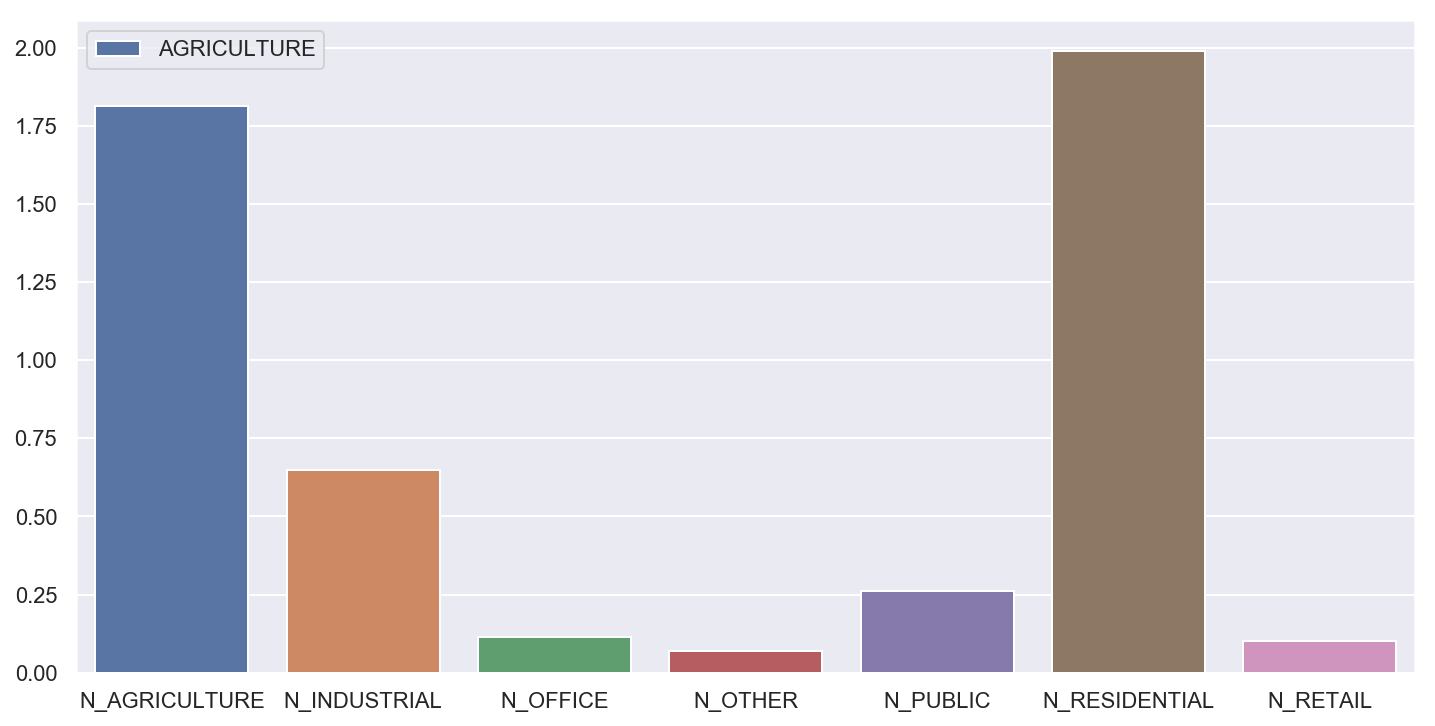

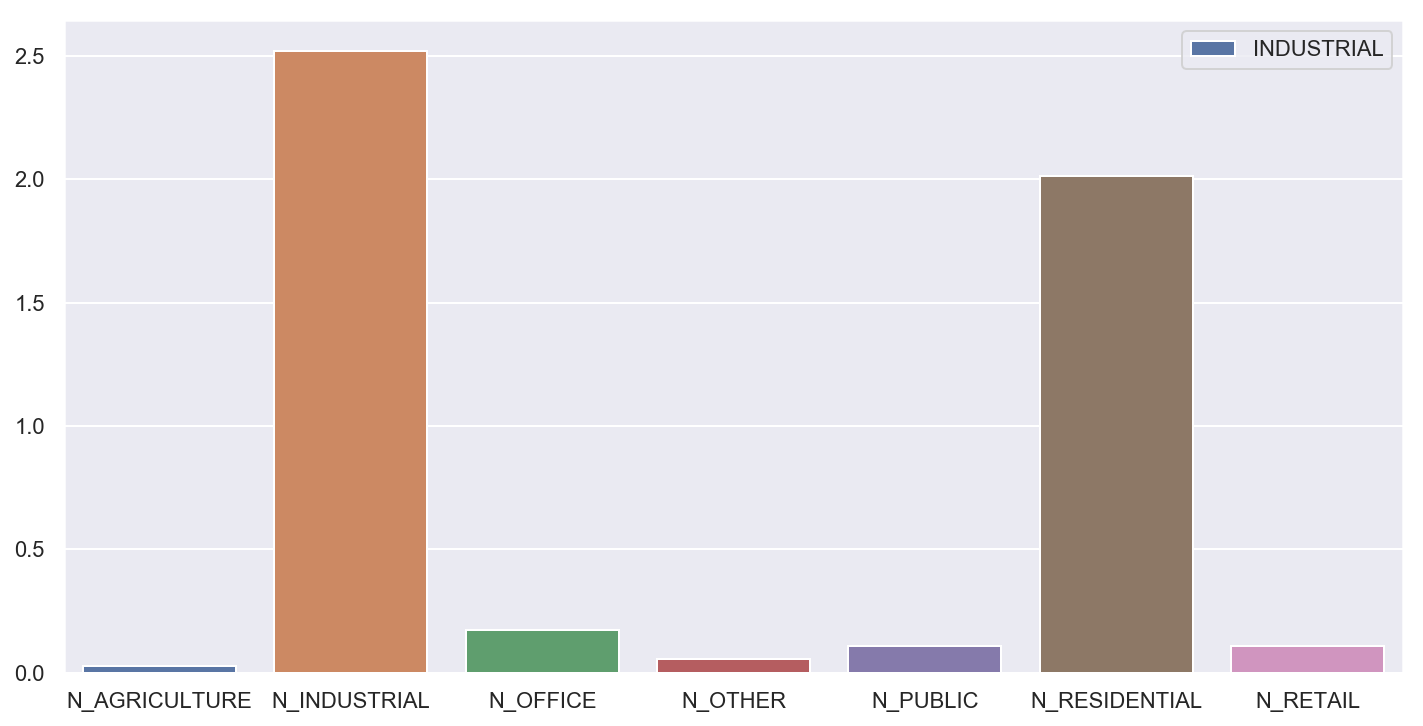

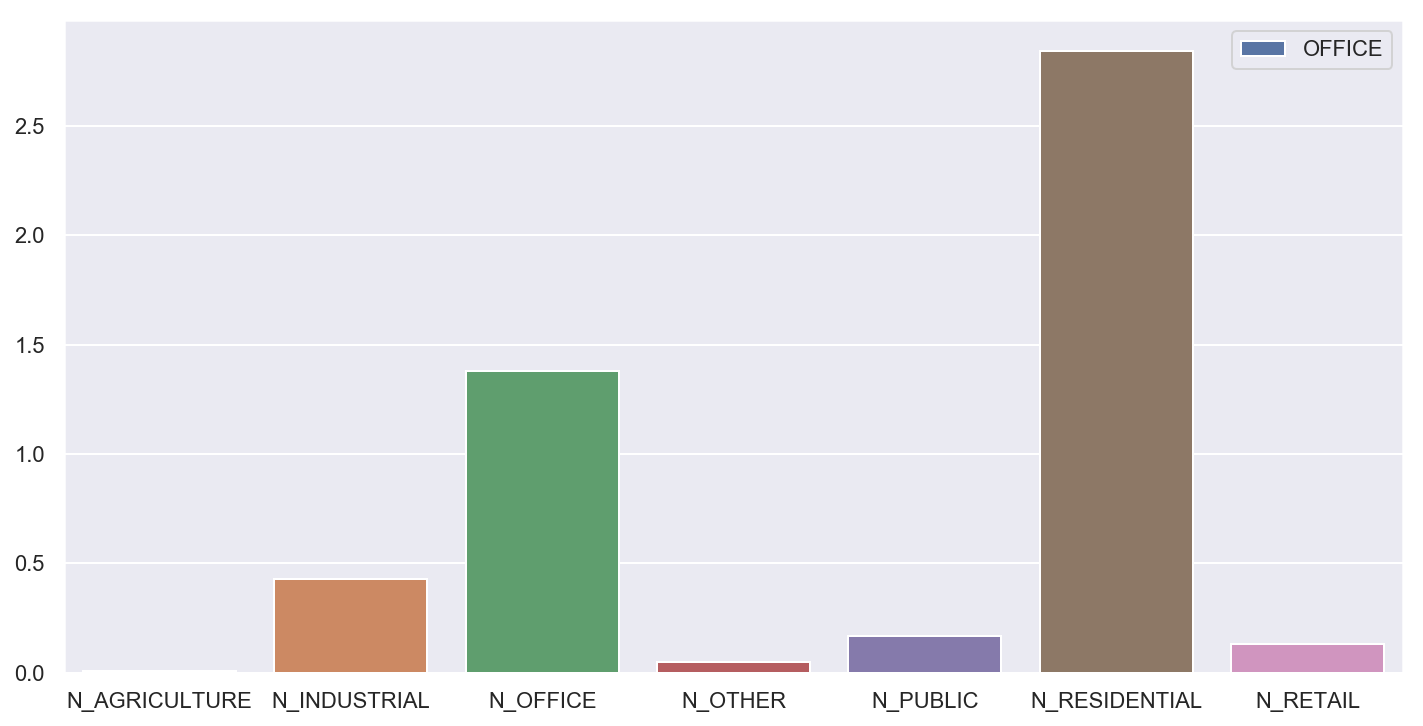

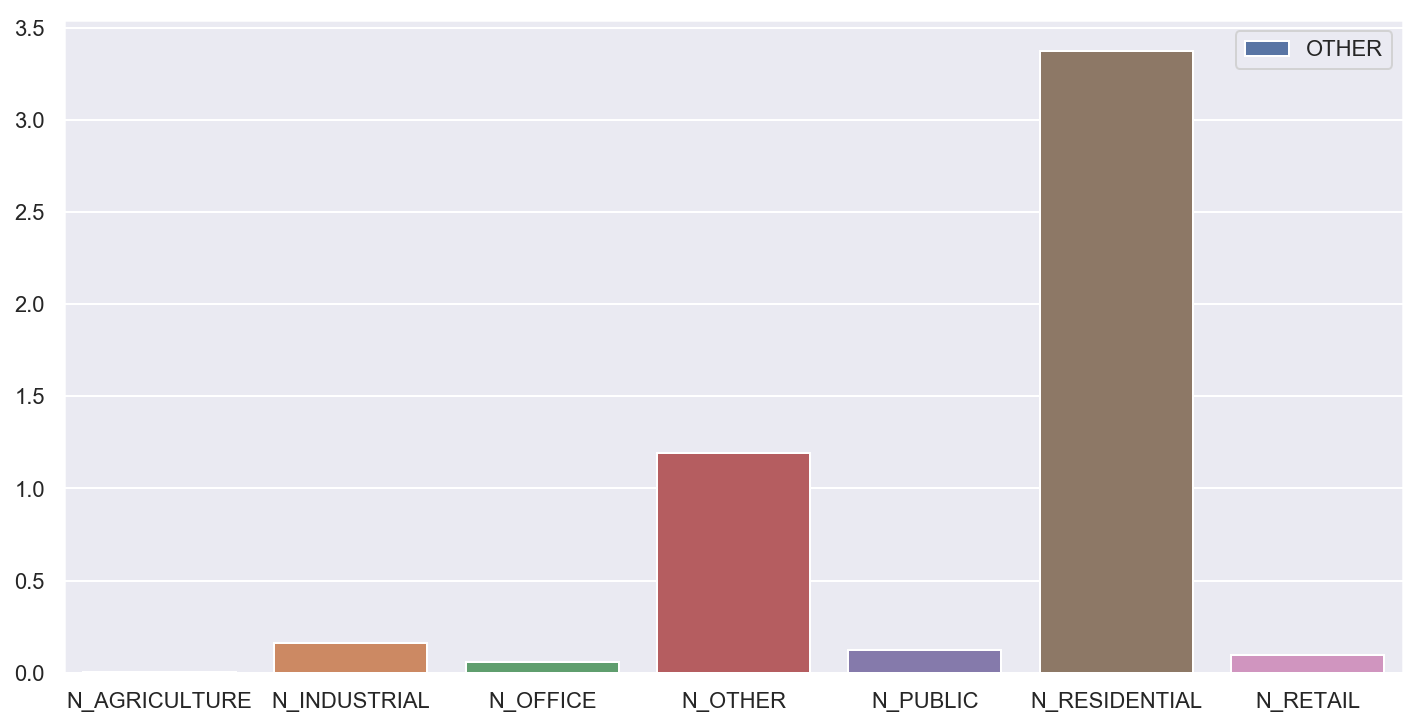

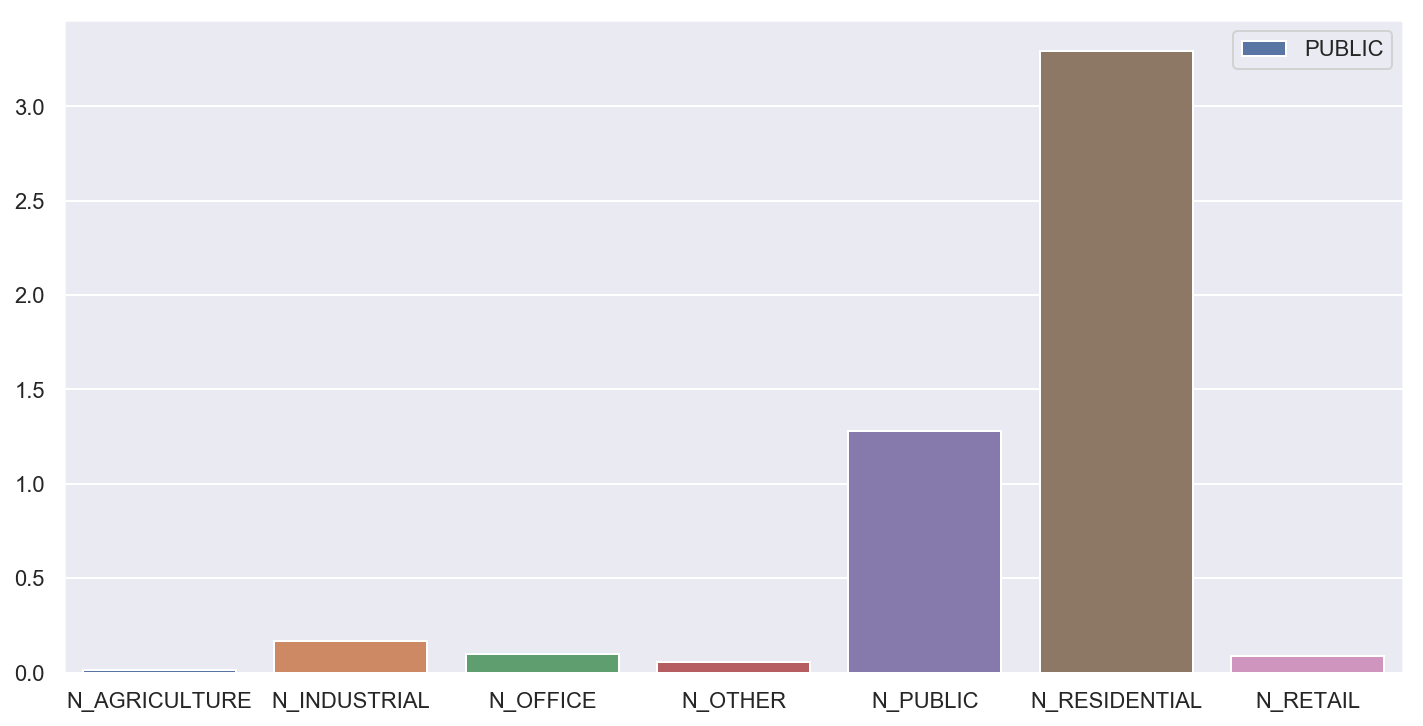

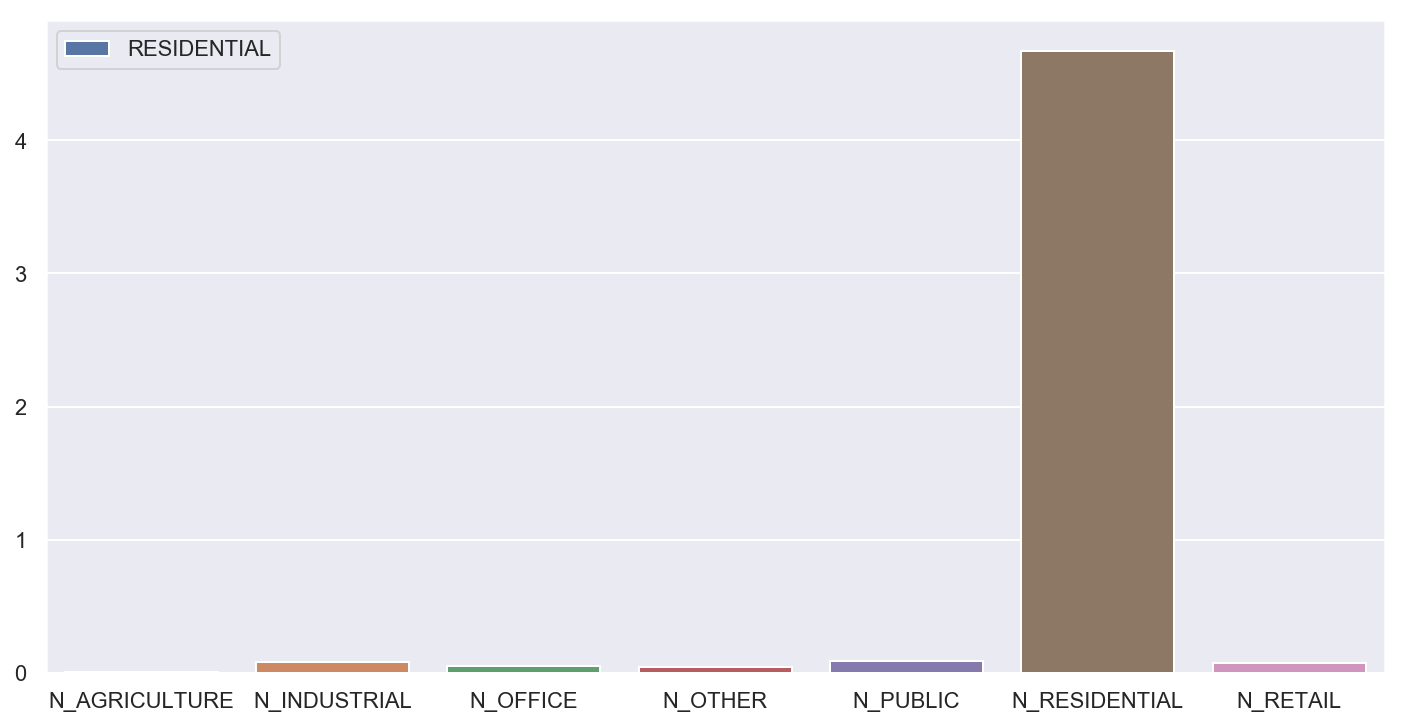

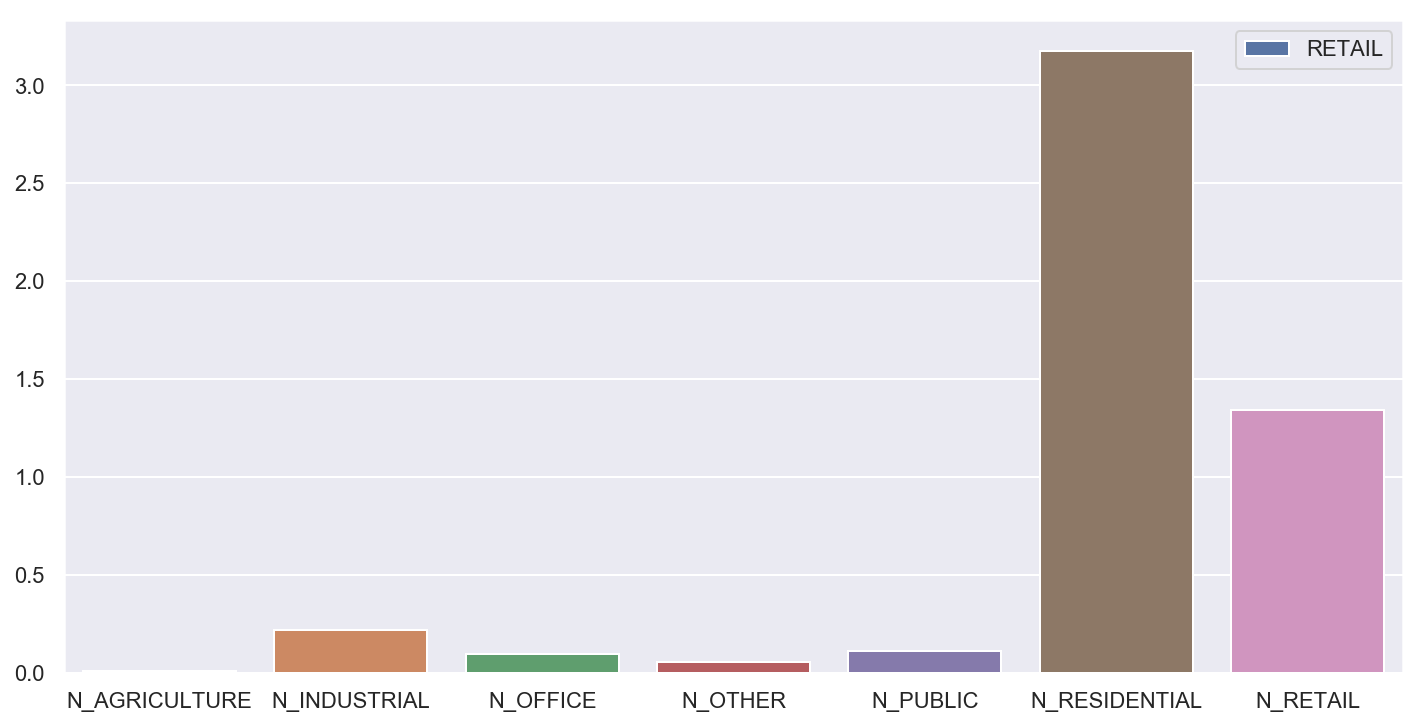

In [109]:
grouped = df_modelar.groupby('CLASE')[df_modelar.columns[-7:]]
for name, group in grouped:  
    values = group[df_modelar.columns[-7:]].mean()
    plt.figure(figsize=(12,6))
    sns.barplot(x=values.index, y =values.values, label=name)
    plt.legend()
    plt.show()

---

# Colores

In [117]:
df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0']

,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0
ID,,,,,,,,,,,
ED9D46EC9089E51C,0.000000e+00,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,1401.000488,1756.994141,7376.529218
F9643836C56CEF97,3.225805e-10,386.998962,543.007788,656.000073,773.999634,895.998505,1029.996167,1209.001526,1448.995605,1837.001917,5925.849598
55C034472ED68EAC,1.105847e-06,445.999637,634.001172,780.000568,902.004053,1025.997009,1157.997681,1304.999585,1501.002661,1830.998926,7098.504905
37BA5591BA9128AF,2.370434e-06,369.002548,509.001099,623.502045,741.999512,865.006531,997.999084,1155.004517,1355.998047,1668.995605,5036.602827
1F0DC2B421224578,0.000000e+00,357.997101,532.001343,655.999054,770.997498,888.997162,1029.000488,1192.003174,1422.001099,1799.502014,6597.430375
...,...,...,...,...,...,...,...,...,...,...,...
3BDA978F257DB89B,0.000000e+00,366.000061,517.001709,645.000195,768.796497,900.996826,1045.001050,1209.003259,1408.999170,1683.998376,15947.624792
B7323DDDF382BB0A,0.000000e+00,304.999225,513.000488,684.996545,844.999158,994.001282,1150.202808,1329.001062,1549.995020,1884.999426,16232.715057
F35B032549B5E76A,3.997917e-05,396.000687,530.996887,637.001221,735.997009,834.503479,946.001526,1085.003357,1275.001465,1603.497803,7368.896682


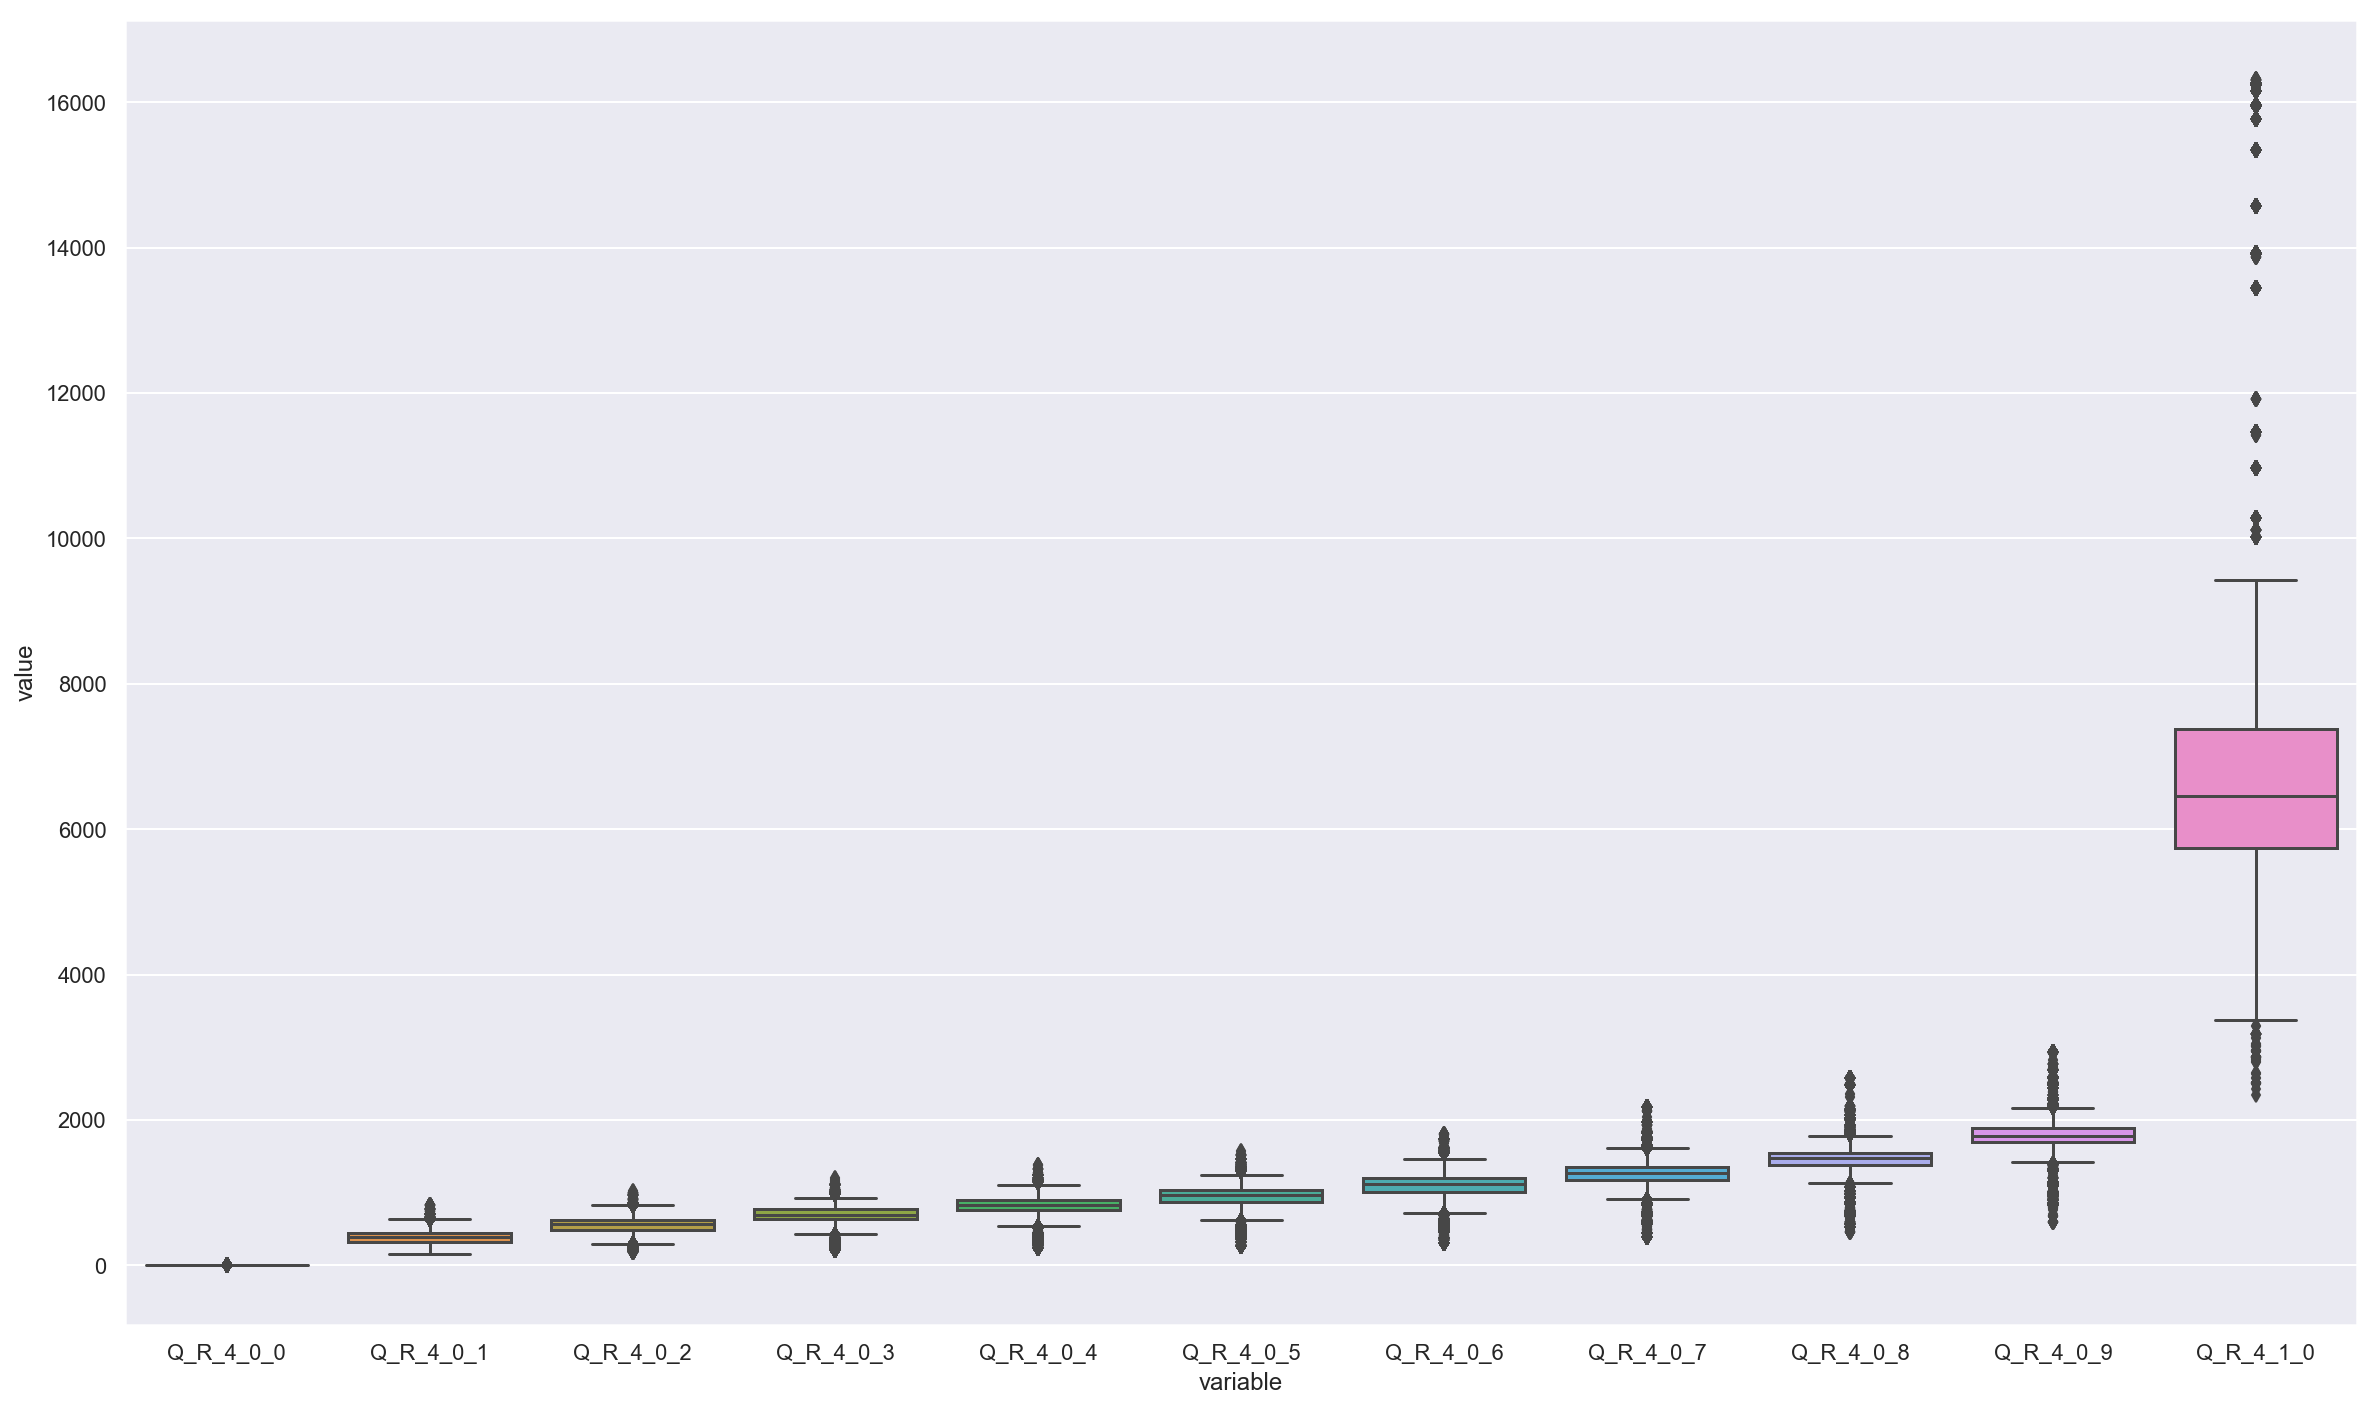

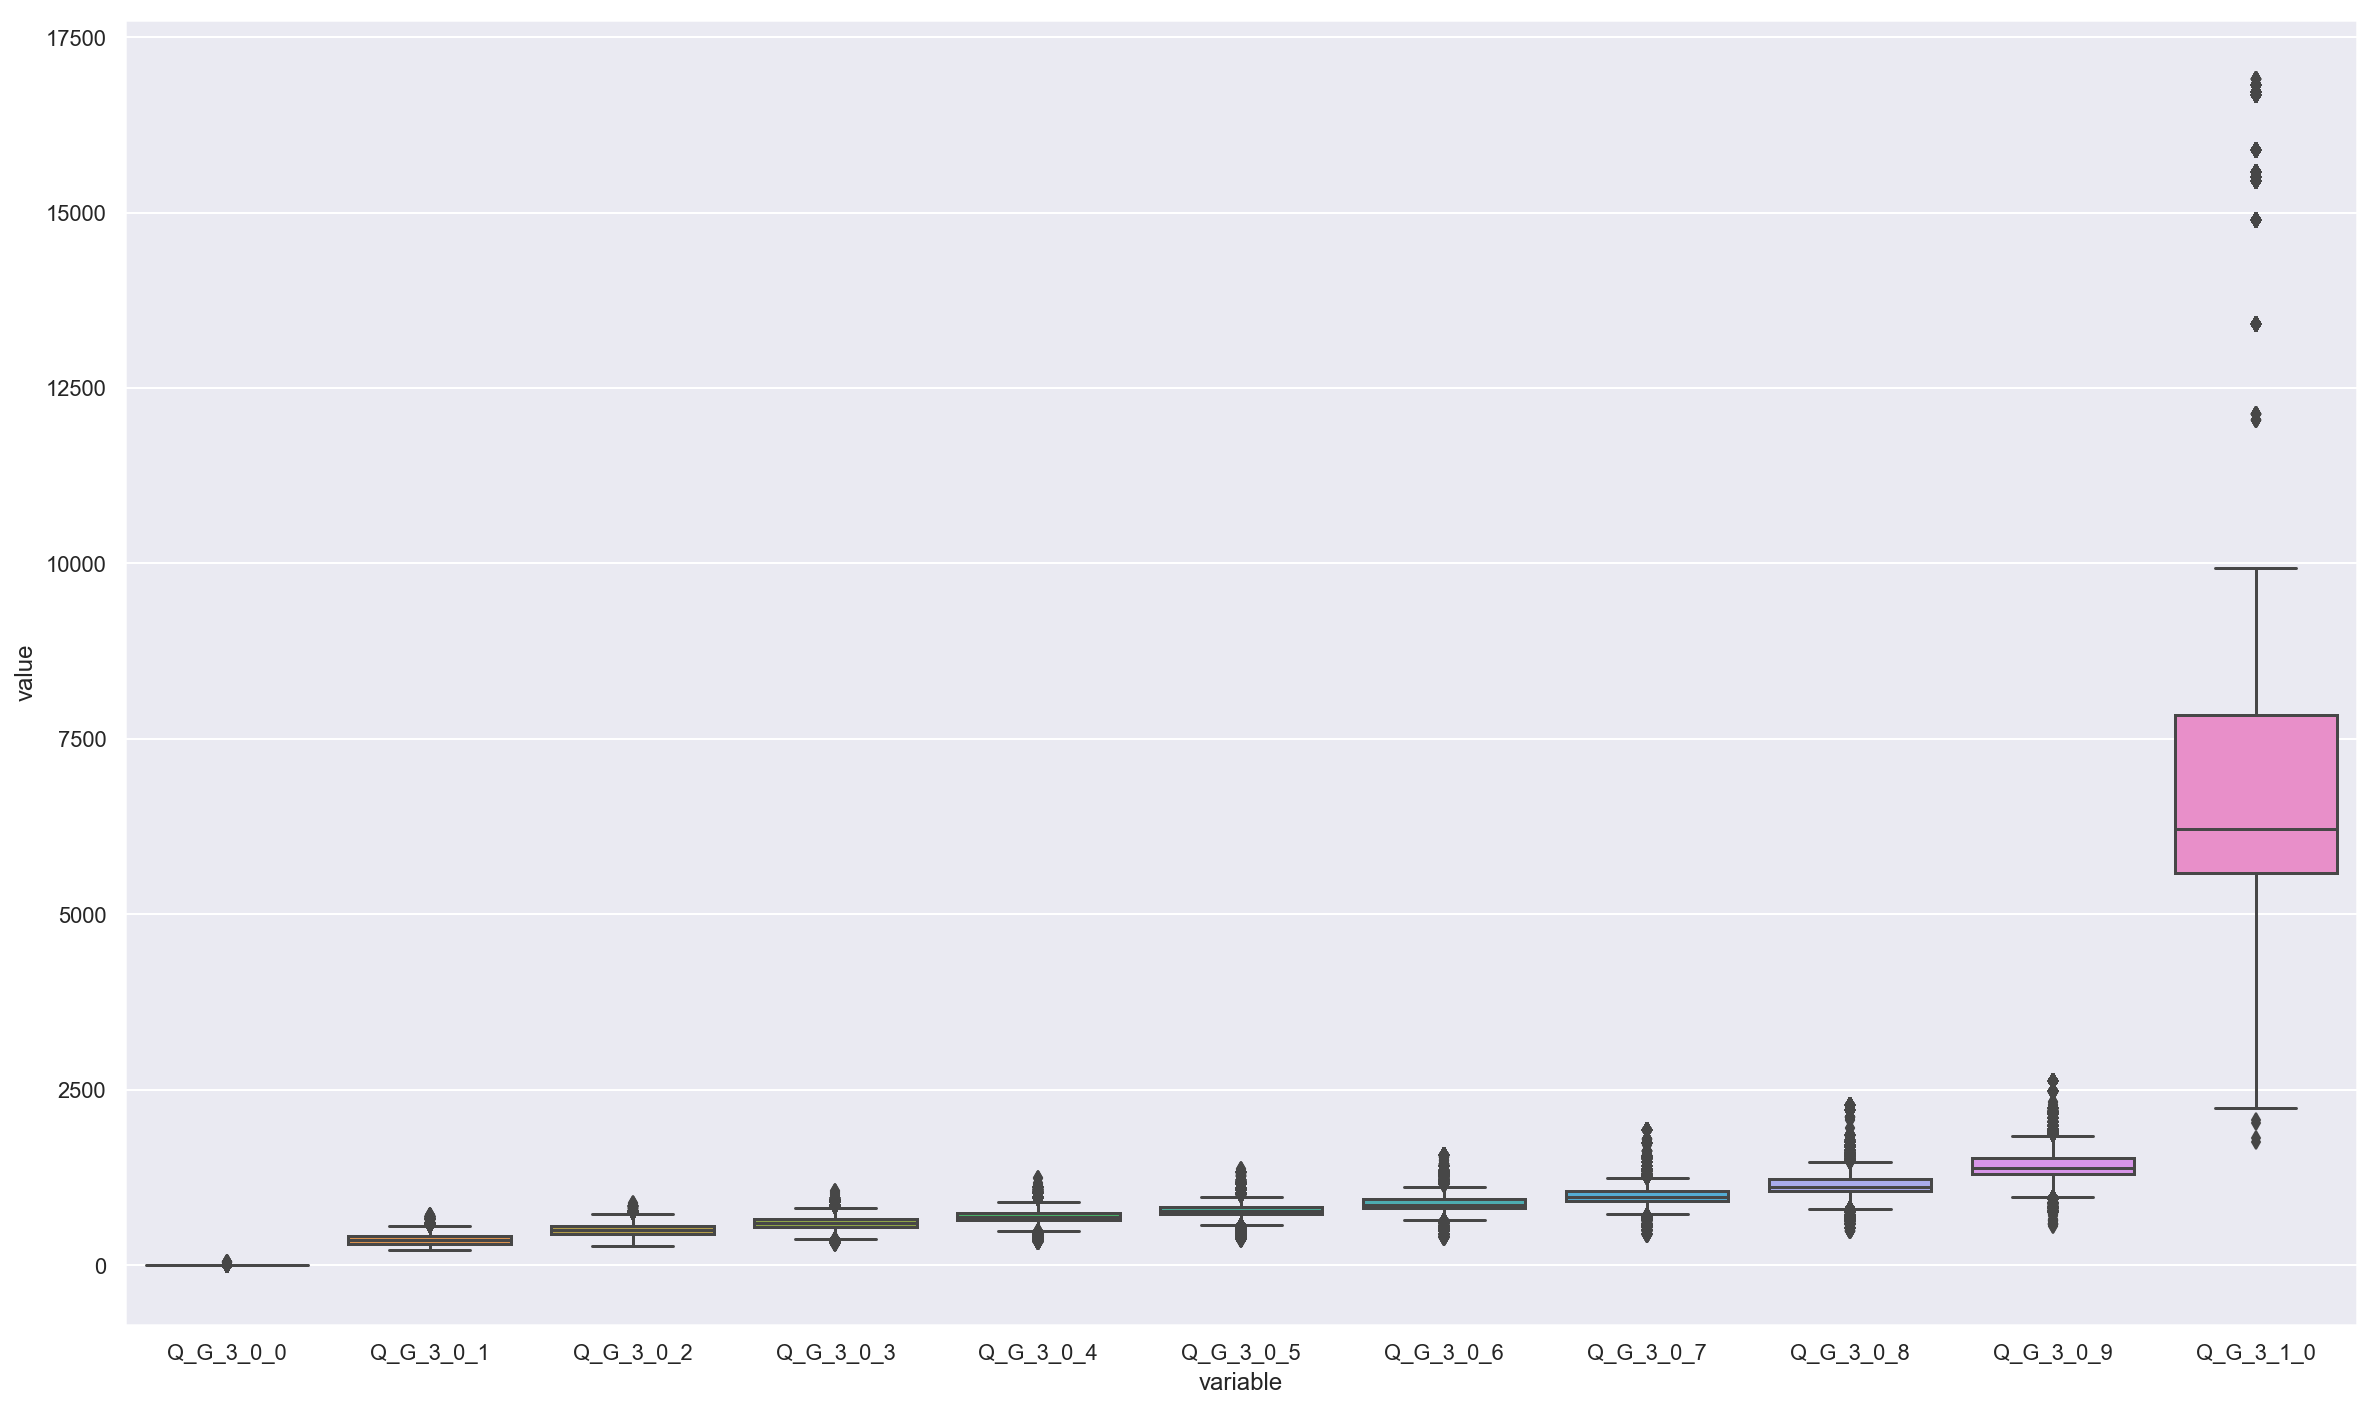

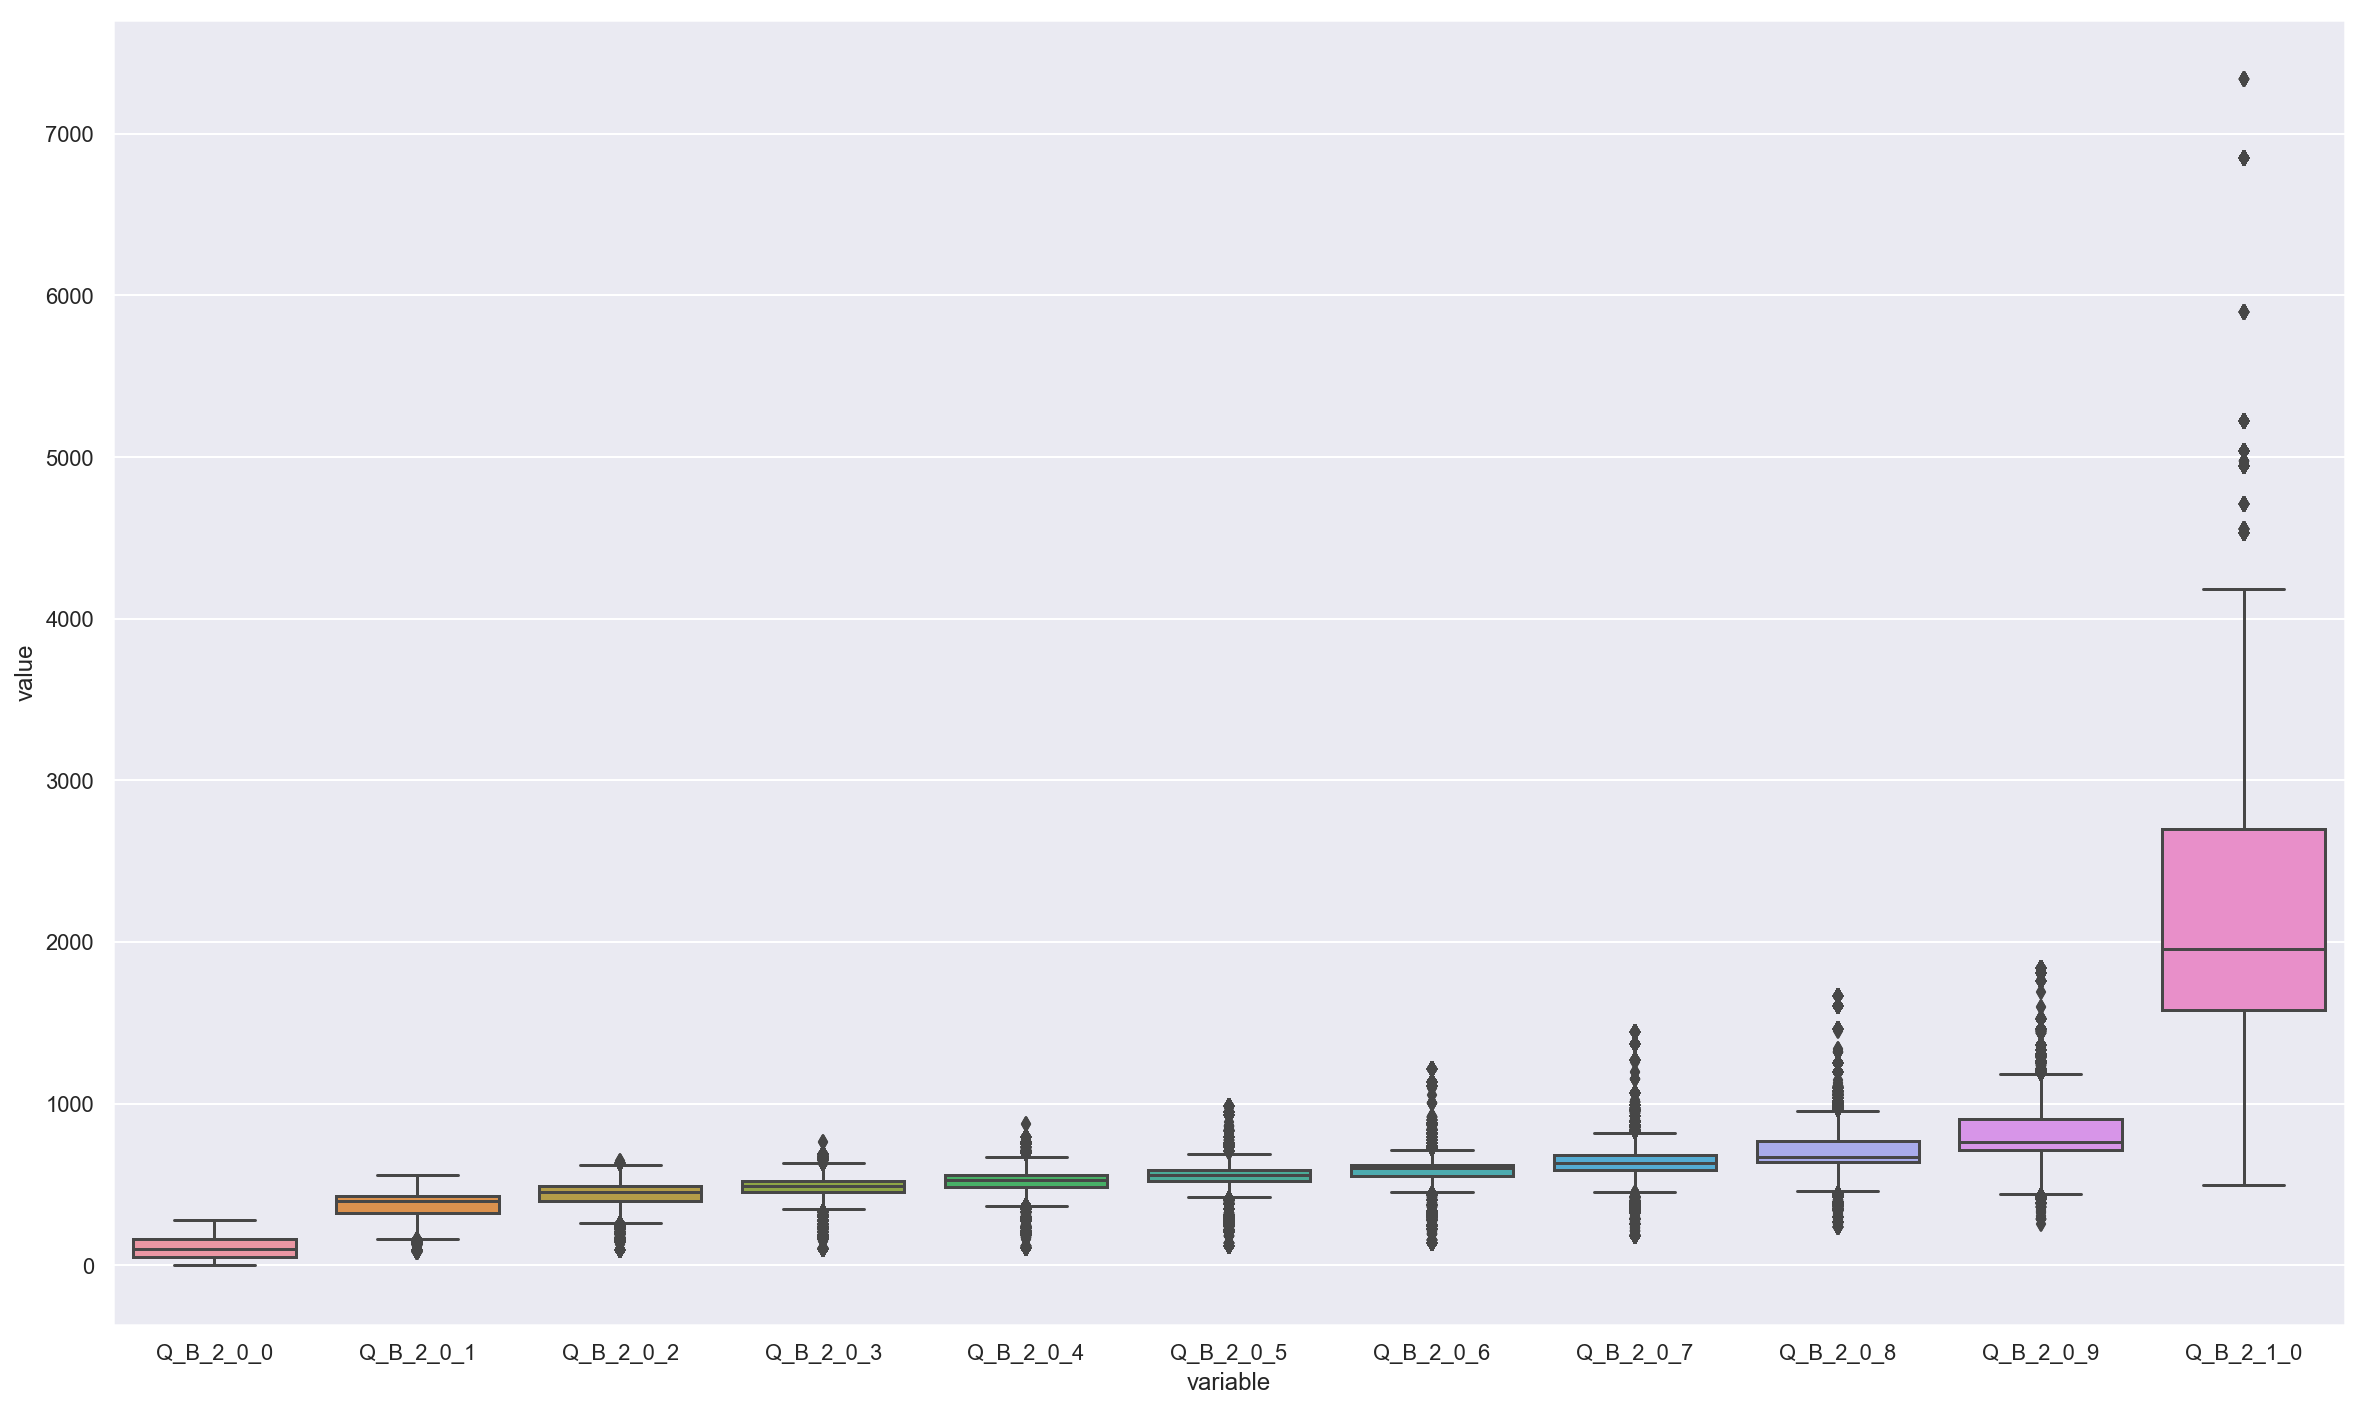

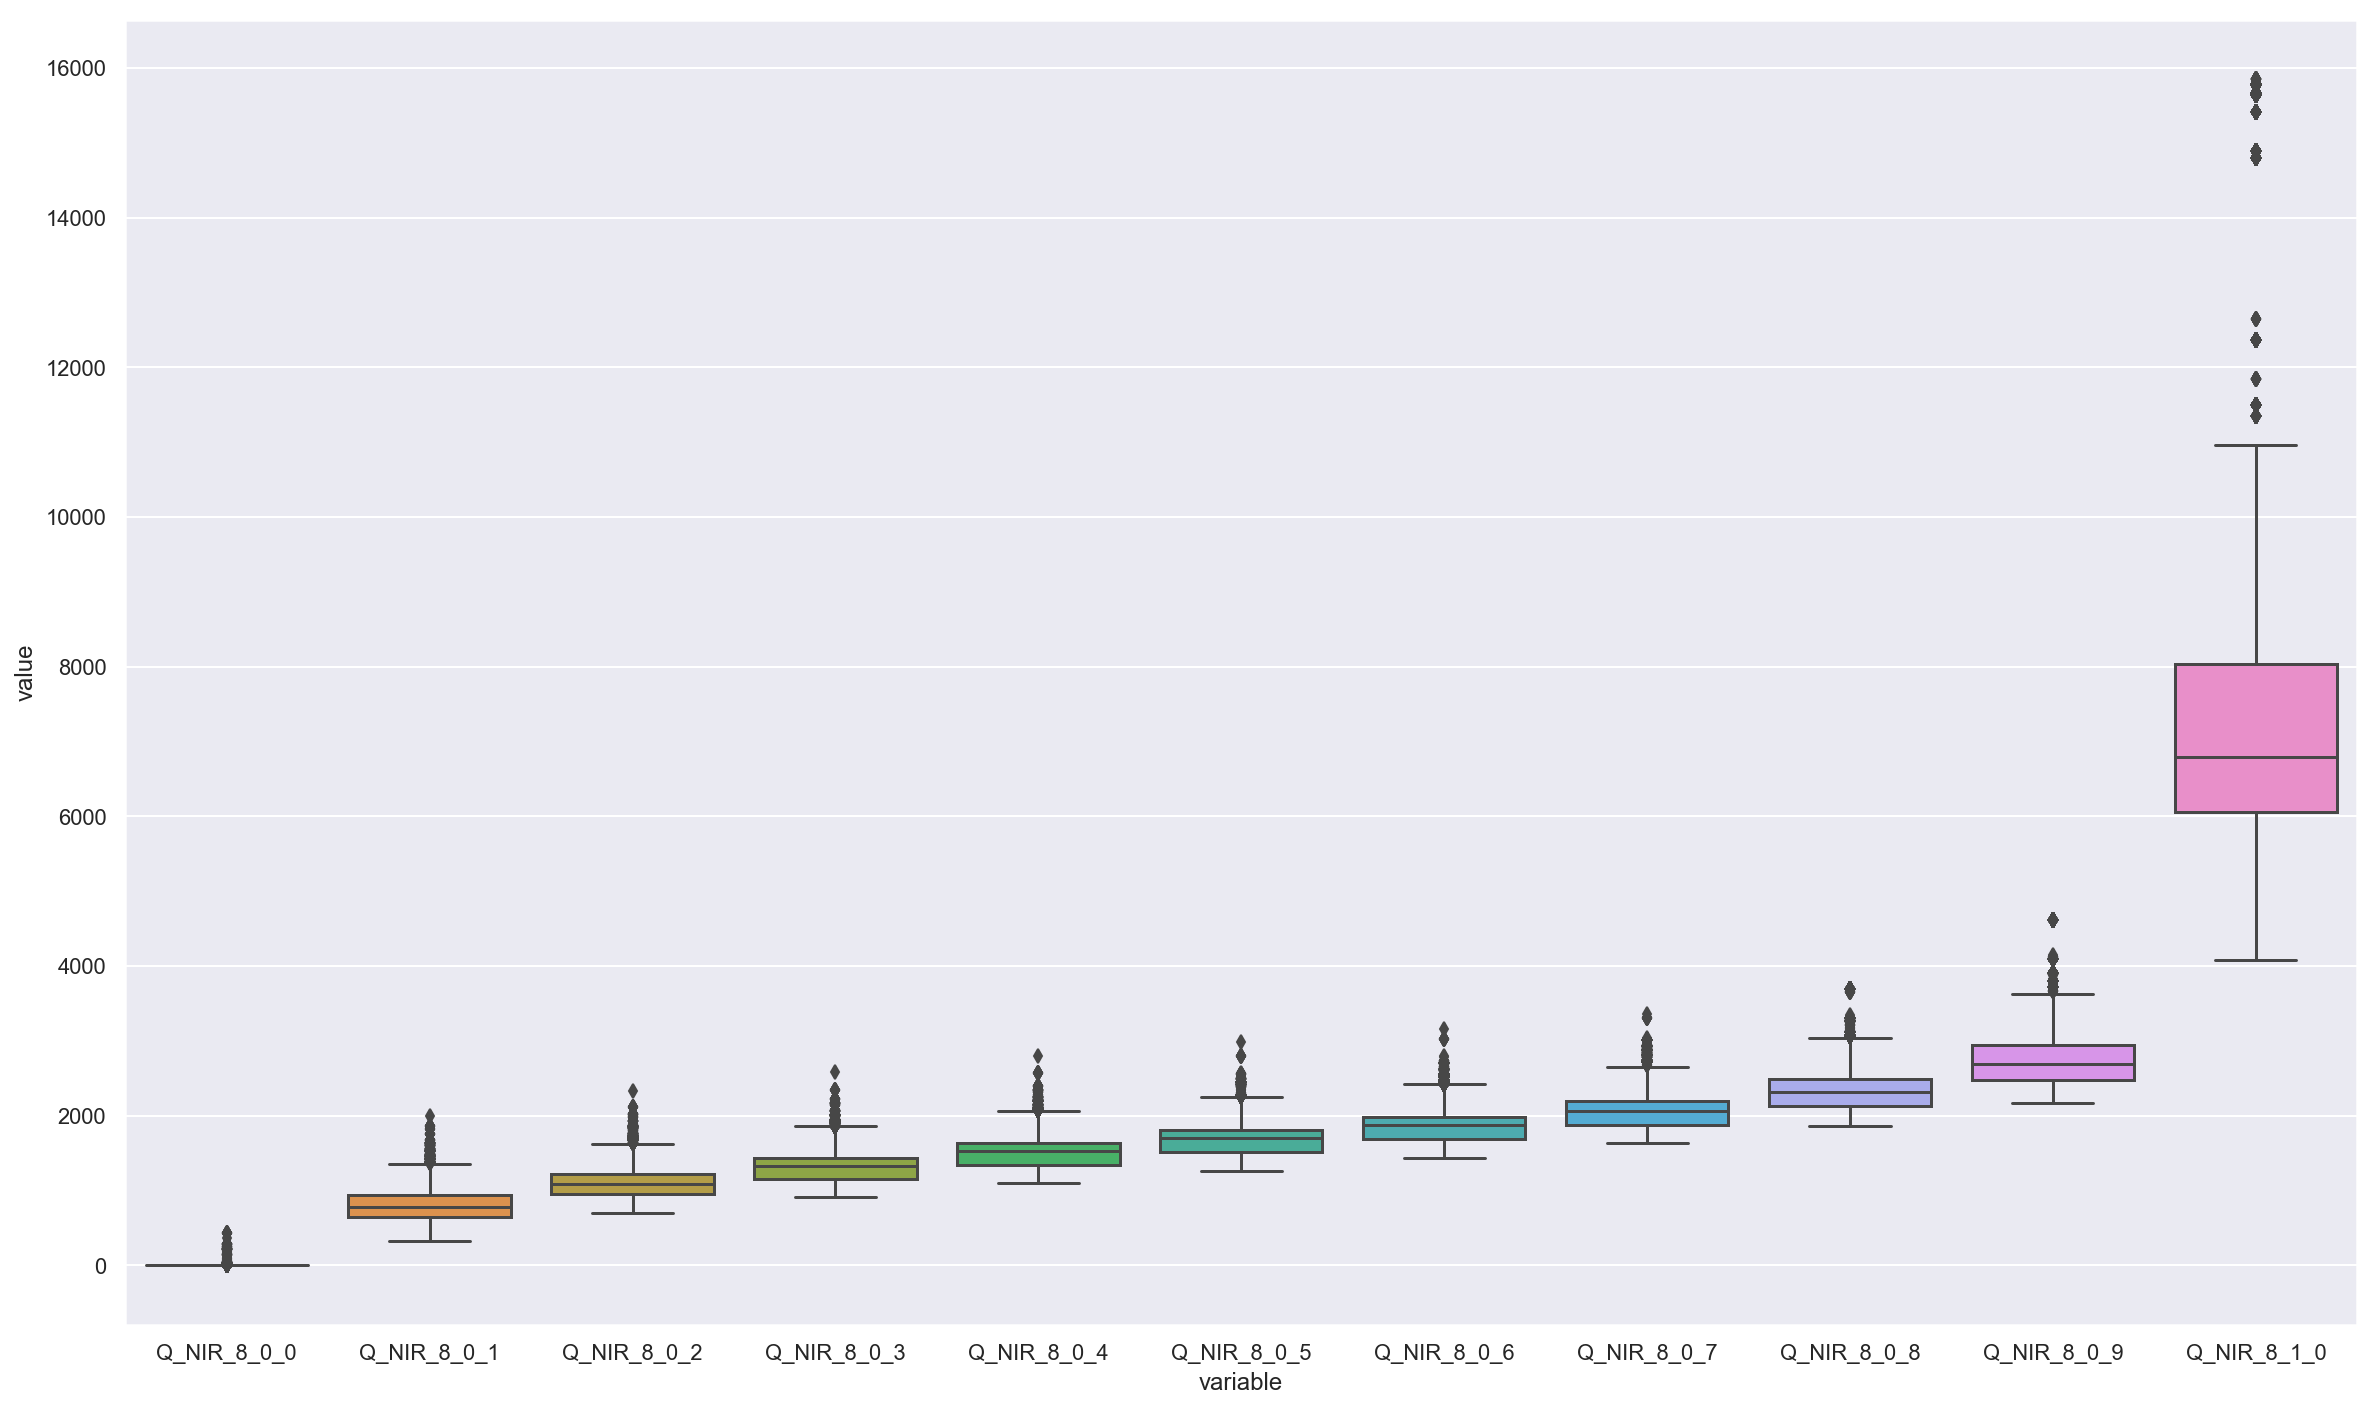

In [126]:
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0']))
plt.show()
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0']))
plt.show()
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0']))
plt.show()
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0']))
plt.show()

# Agrupaciones de los colores

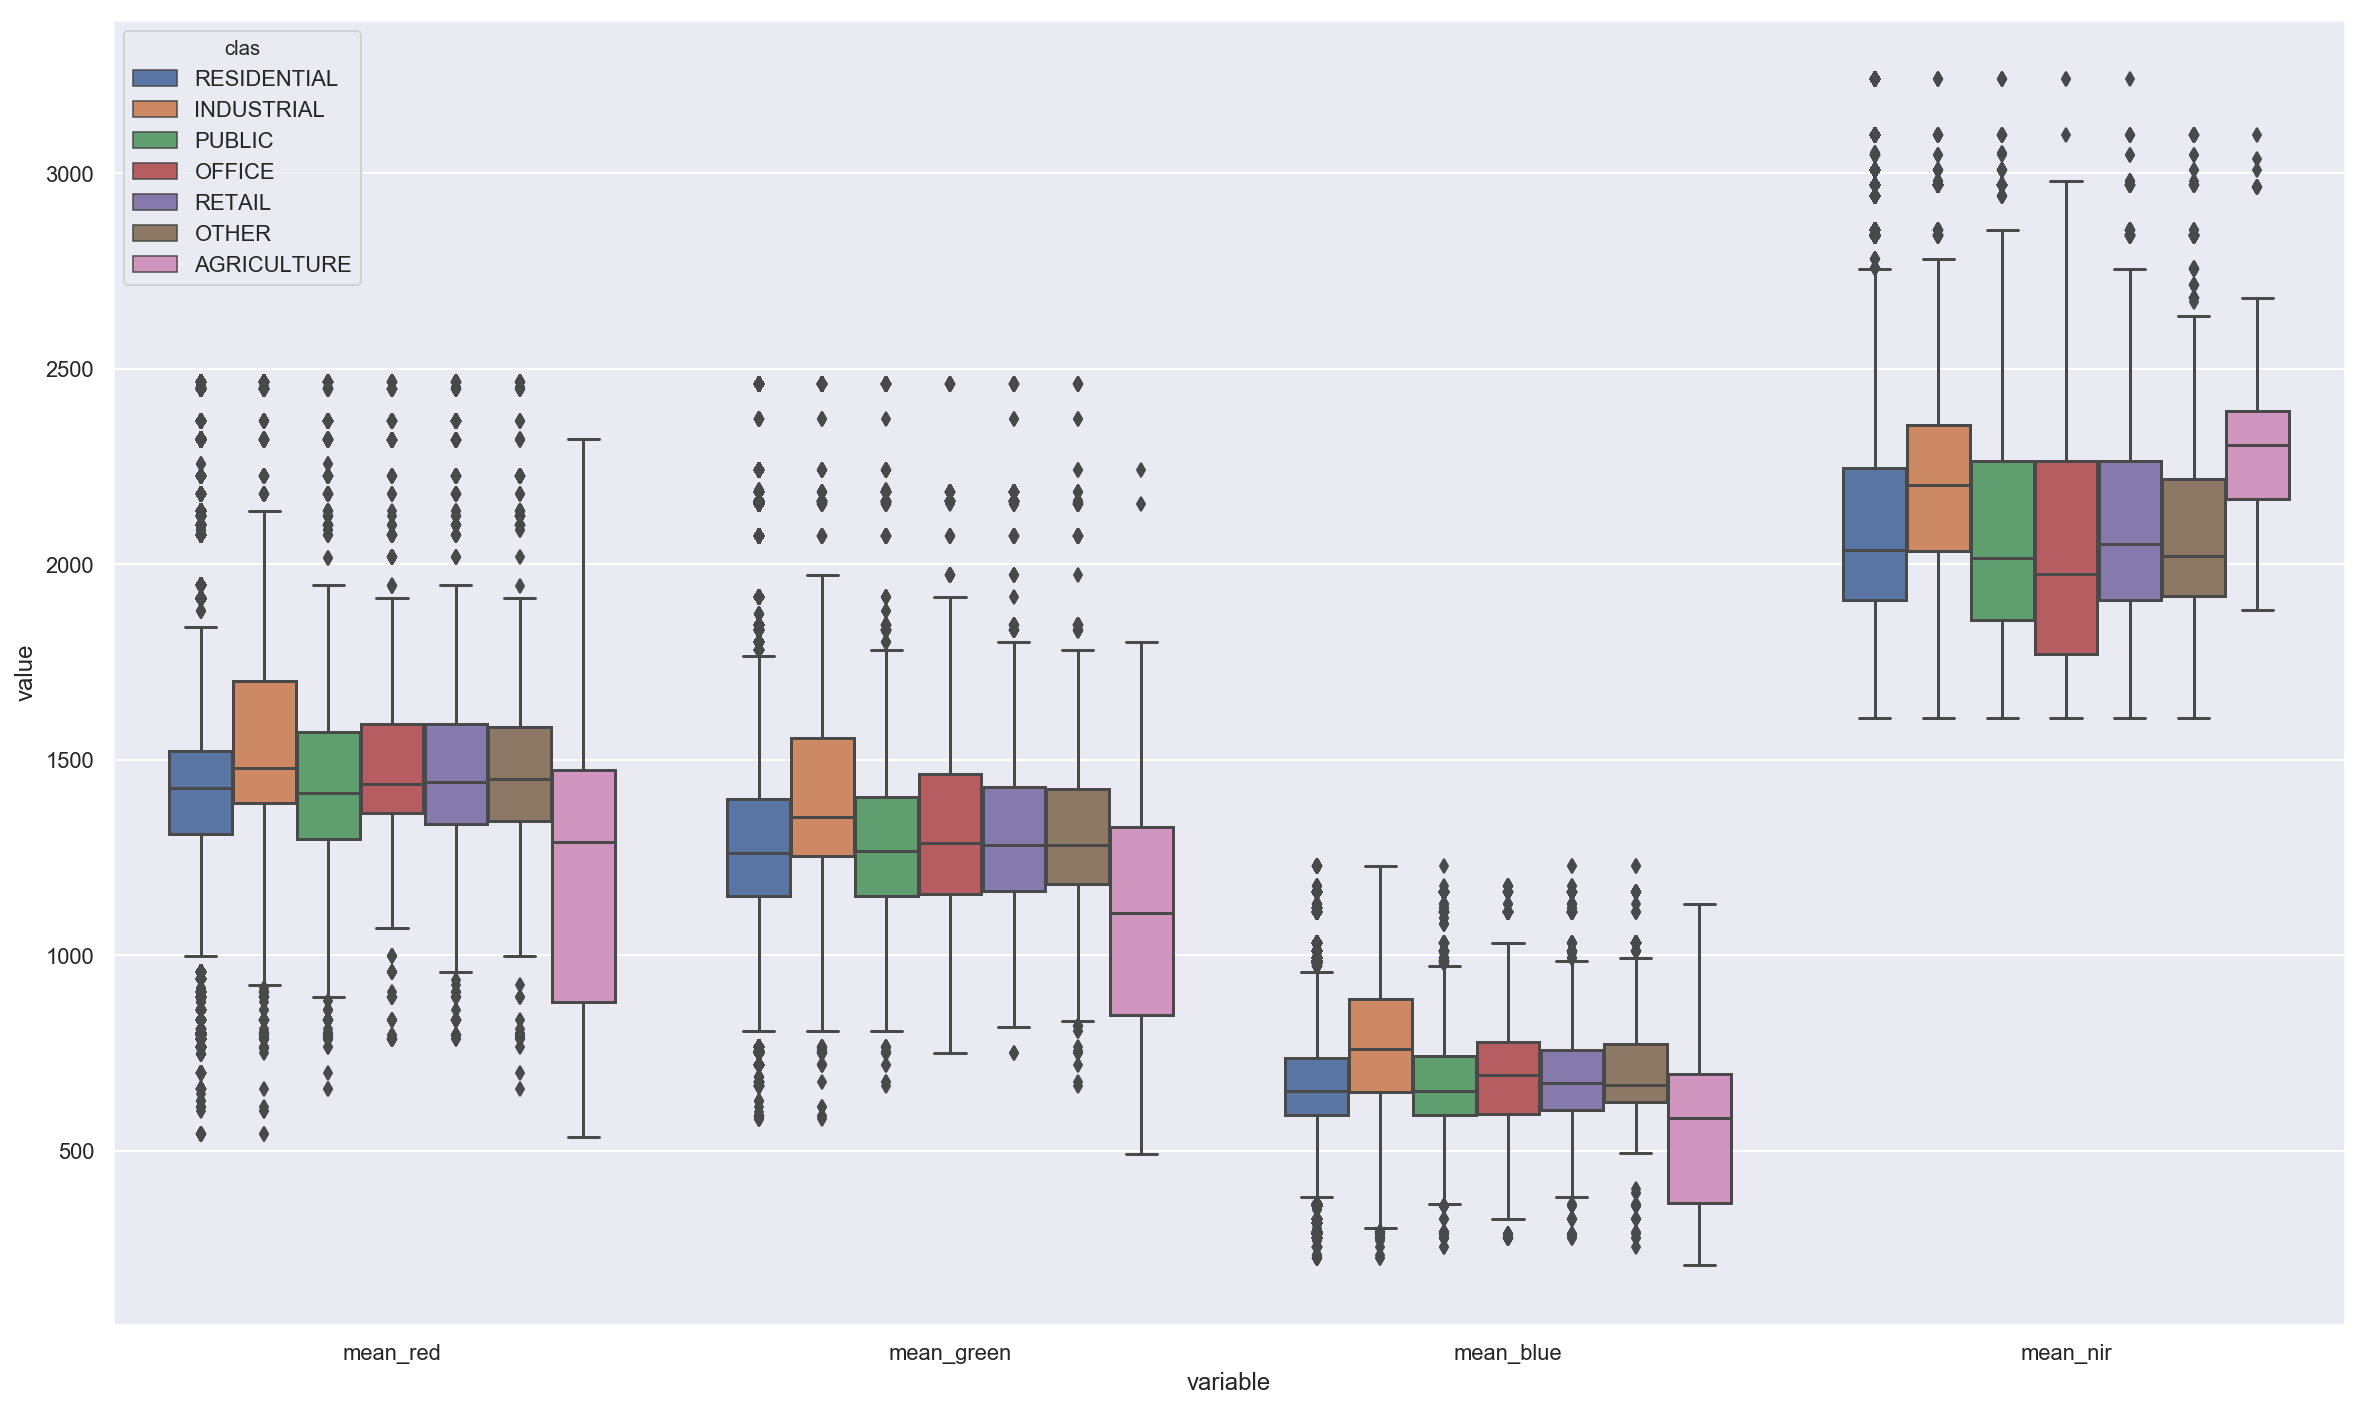

In [176]:
df_modelar['mean_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
df_modelar['mean_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].mean(axis=1)
df_modelar['mean_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
df_modelar['mean_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

data = pd.melt(df_modelar.loc[:, 'mean_red':'mean_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

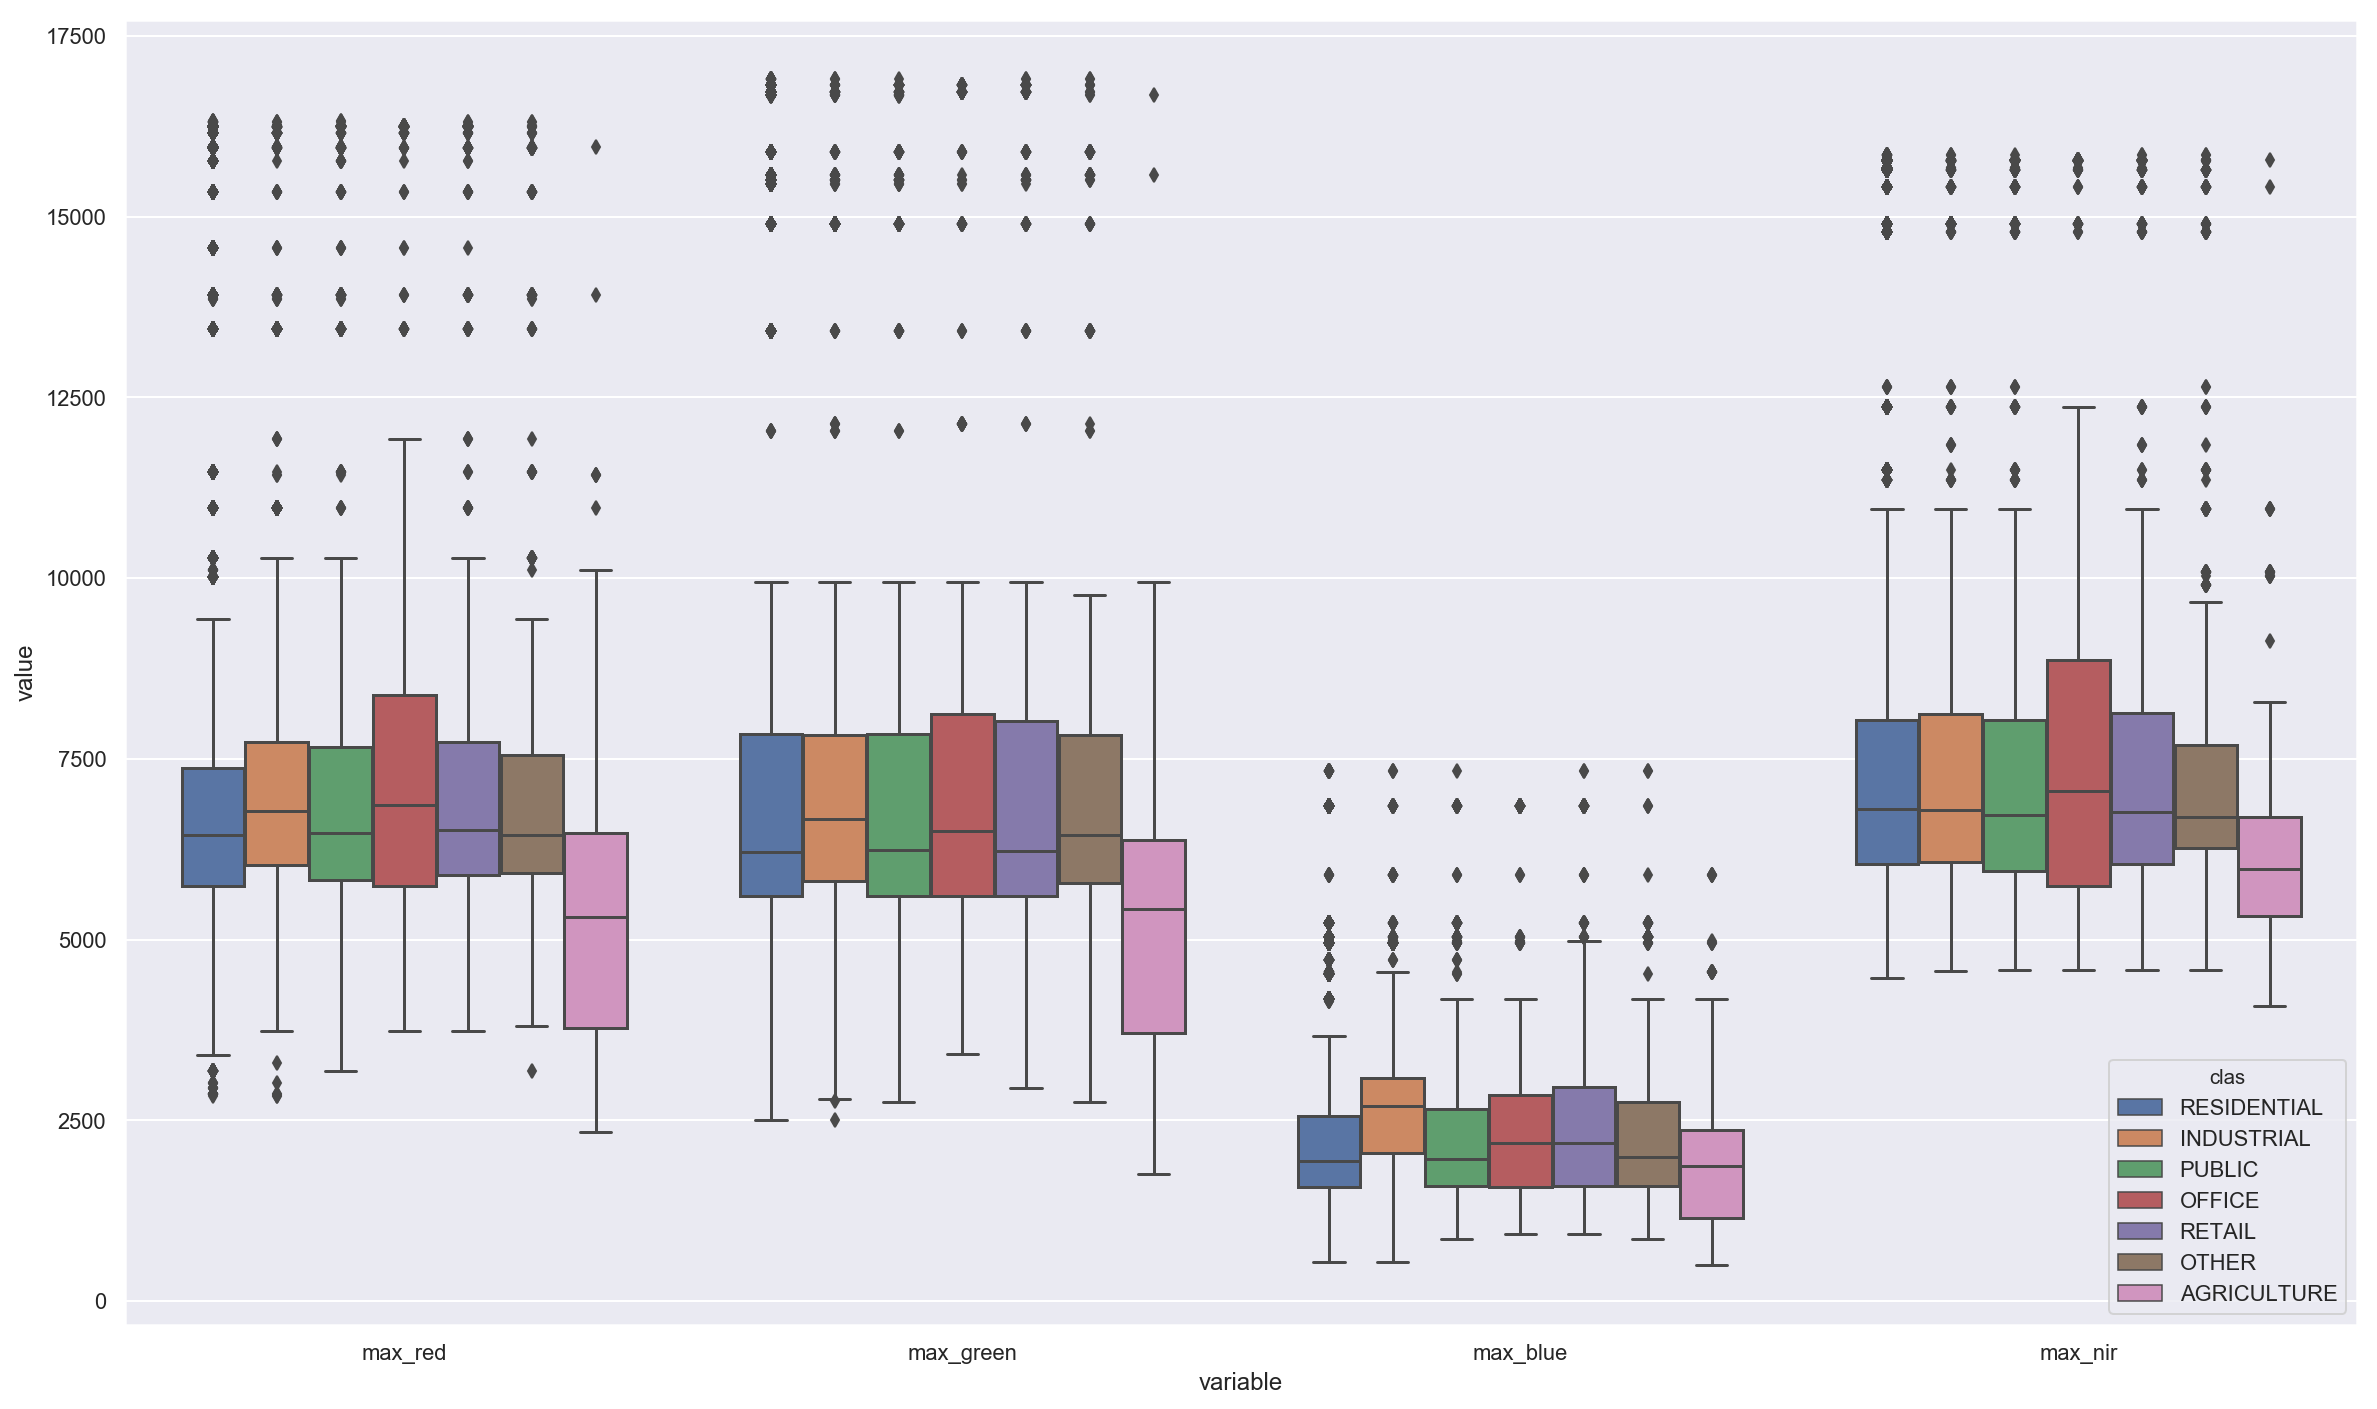

In [175]:
df_modelar['max_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
df_modelar['max_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
df_modelar['max_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
df_modelar['max_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

data = pd.melt(df_modelar.loc[:, 'max_red':'max_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

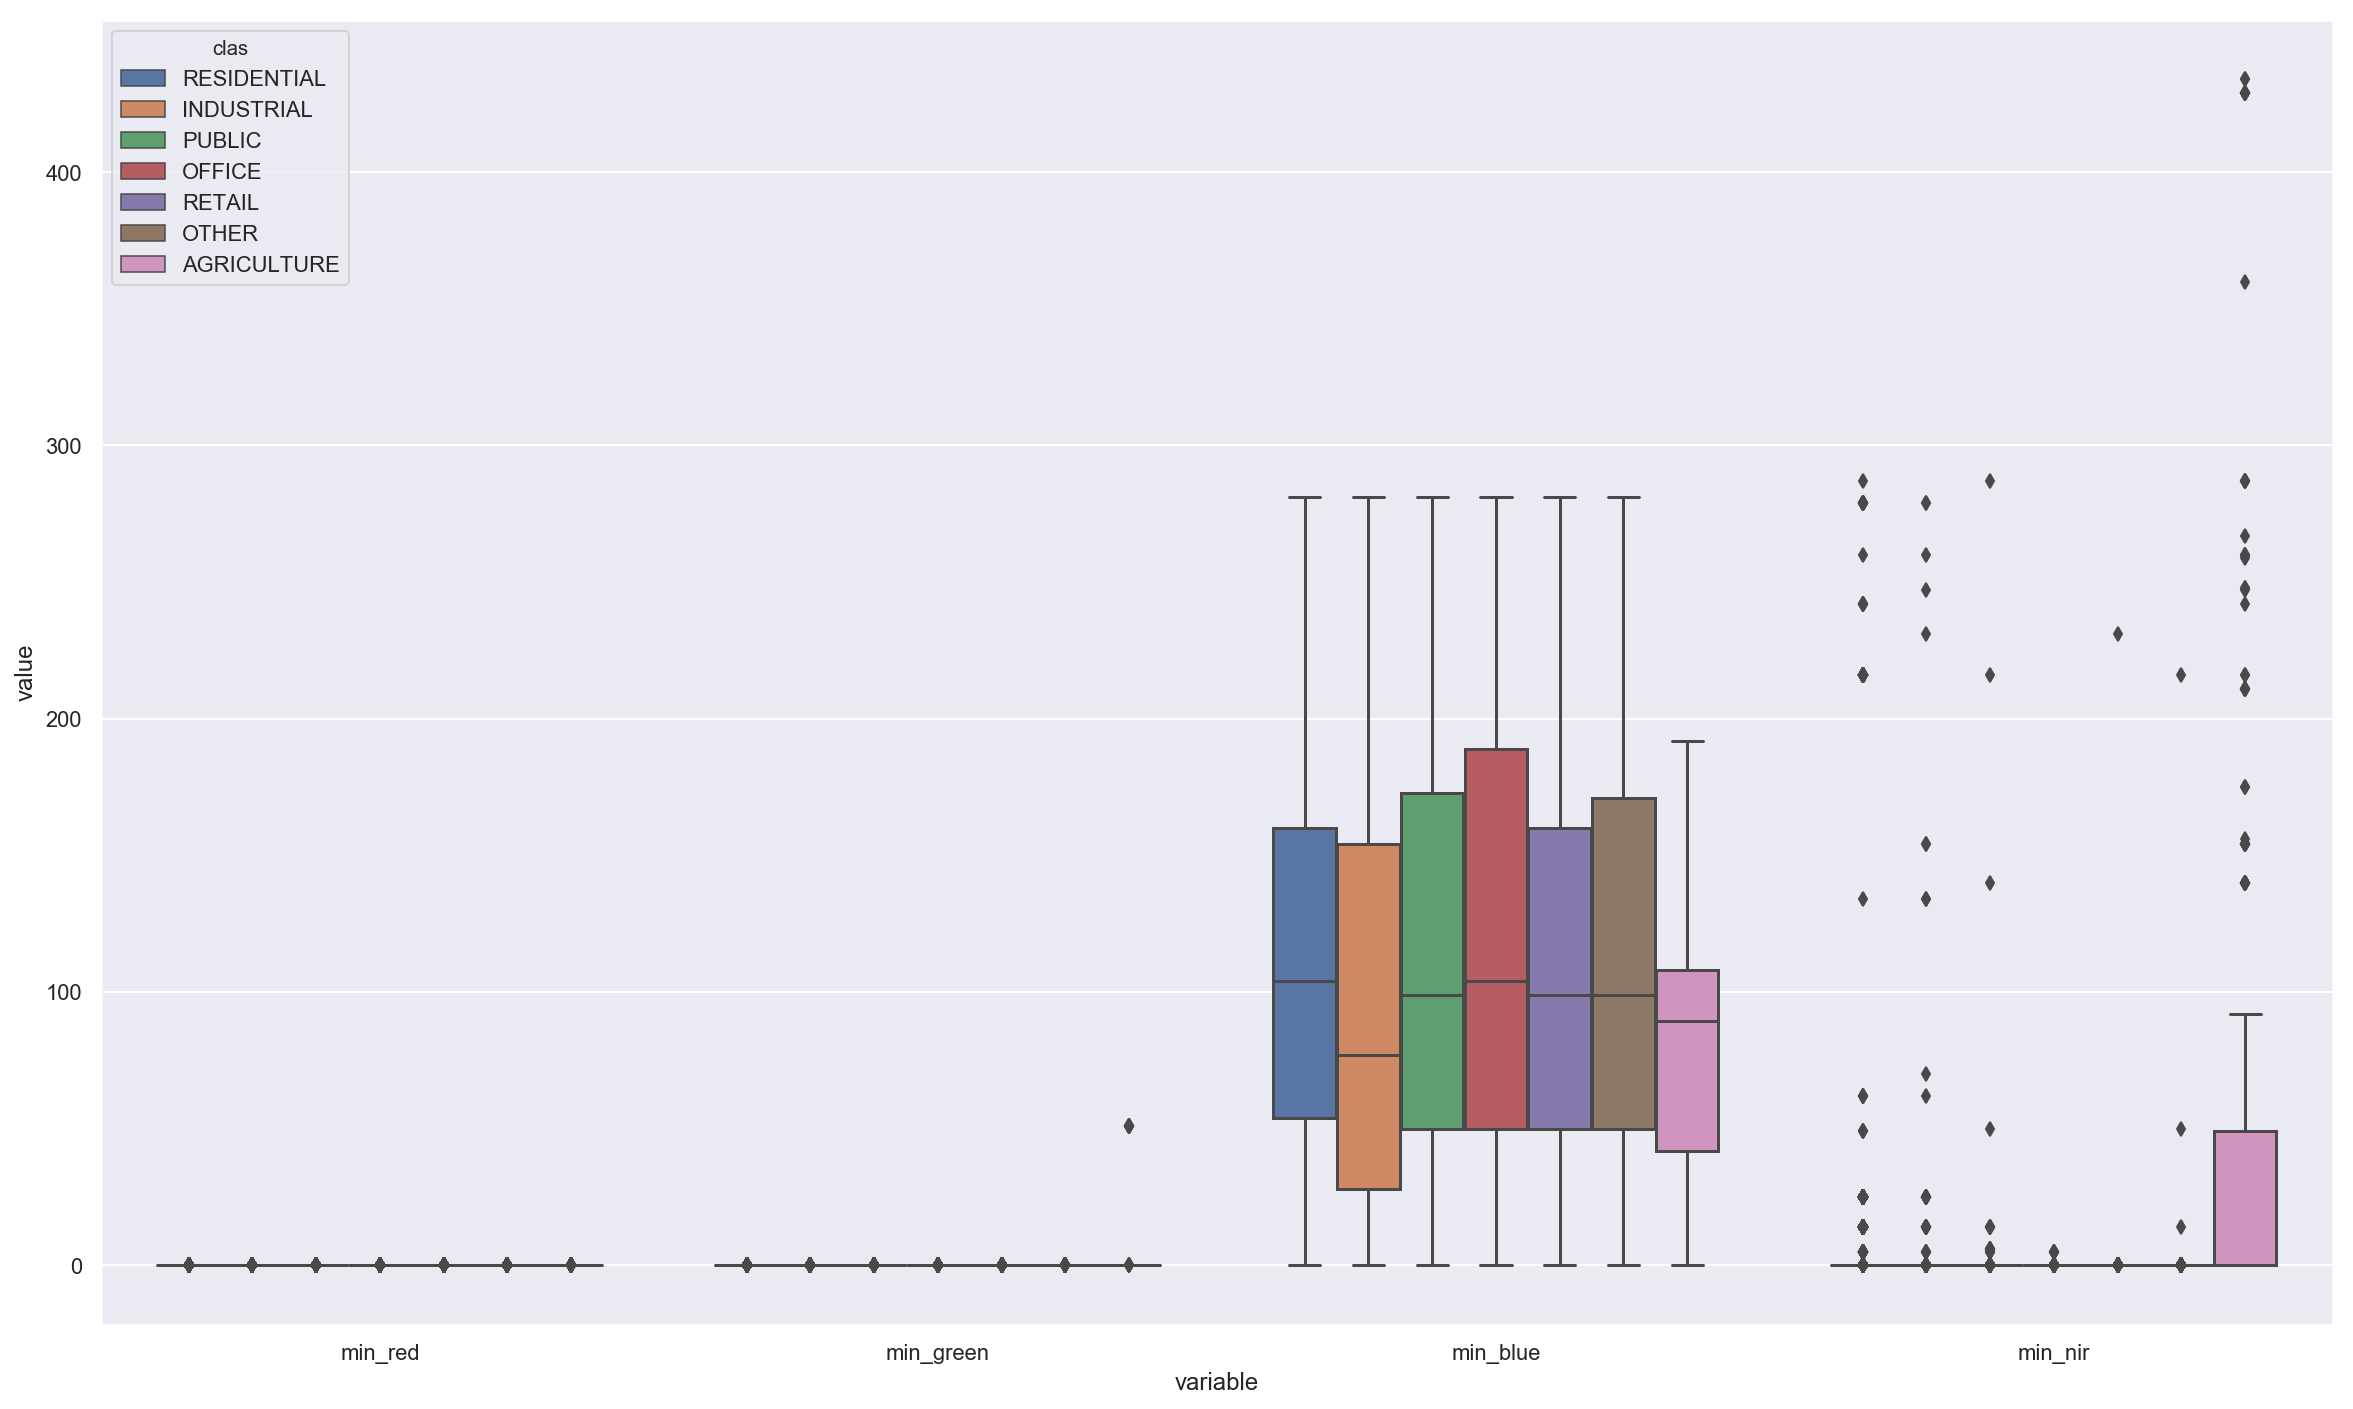

In [174]:
df_modelar['min_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
df_modelar['min_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
df_modelar['min_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
df_modelar['min_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

data = pd.melt(df_modelar.loc[:, 'min_red':'min_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

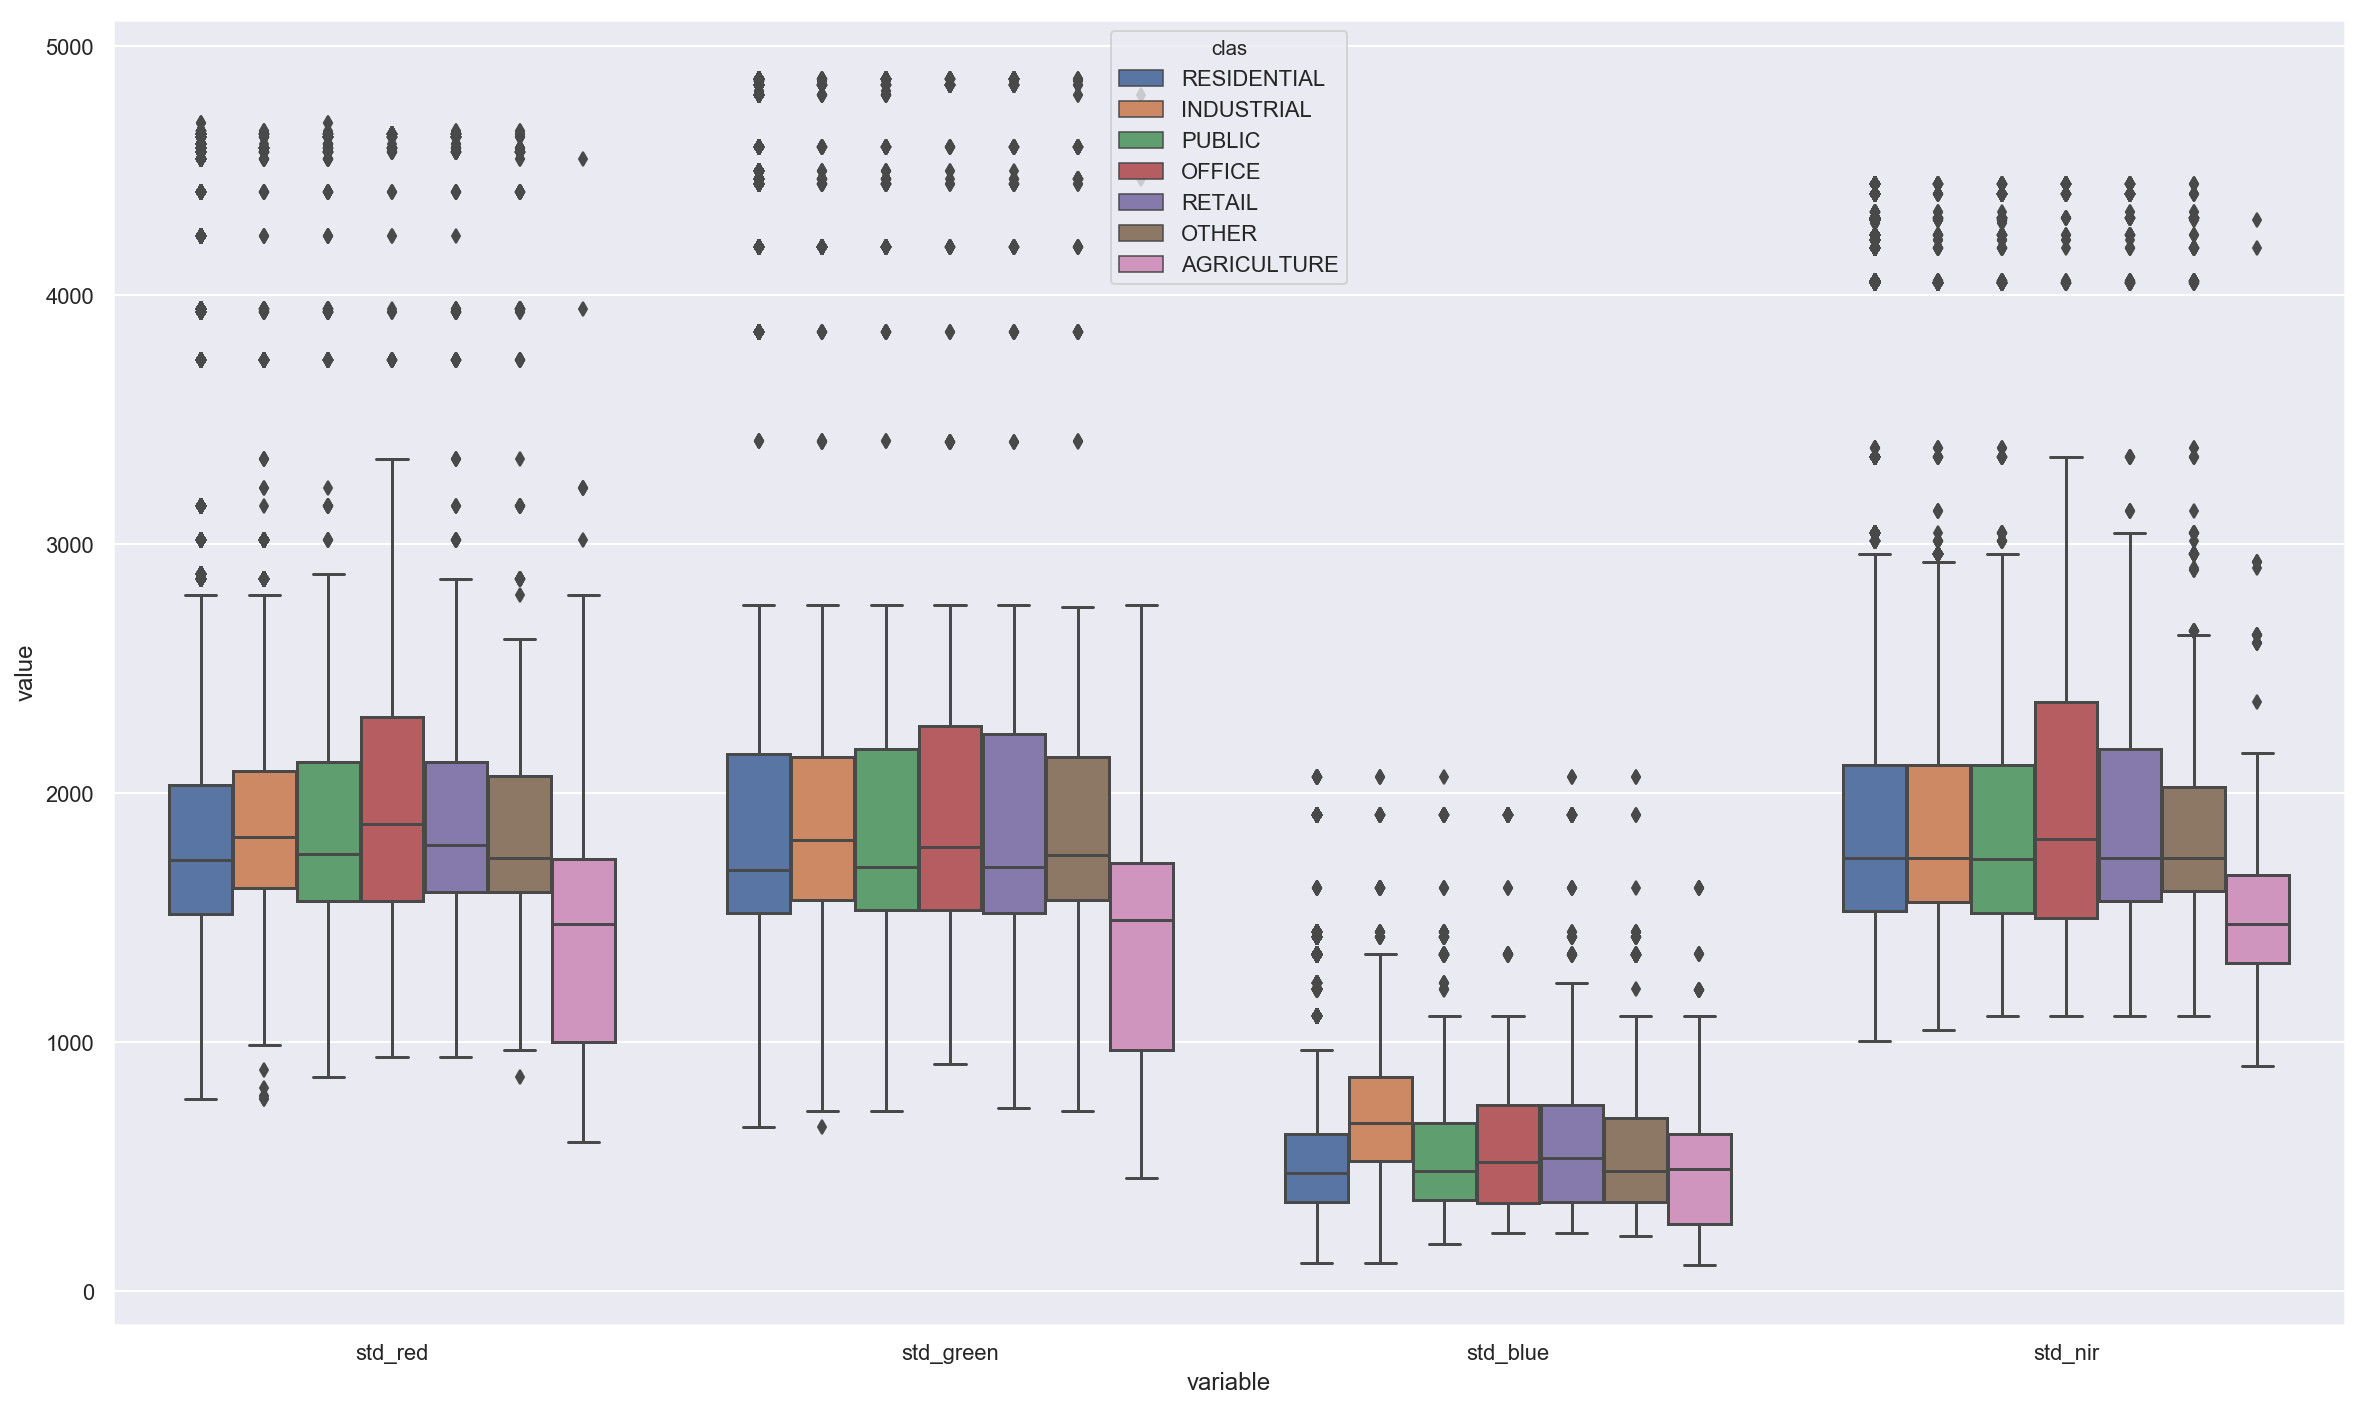

In [173]:
df_modelar['std_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
df_modelar['std_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
df_modelar['std_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
df_modelar['std_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)

data = pd.melt(df_modelar.loc[:, 'std_red':'std_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

In [130]:
df_modelar.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID', 'CLASE',
       'distance_to_center', 'N_AGRICULTURE', 'N_INDUSTRIAL', 'N_OFFICE',
       'N_OTHER', 'N_PUBLIC', 'N_RESIDENTIAL', 'N_RETAIL', 'mean_red',
       'mean_green', 'mean_blue', 'mean_nir', 'max_red', 'max_

In [139]:
df_modelar[df_modelar['CLASE']=='AGRICULTURE'][['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'mean_red', 'max_red', 'min_red','std_red','CLASE']]

,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,mean_red,max_red,min_red,std_red,CLASE
ID,,,,,,,,,,,,,,,,
AA236D8FA8AD6934,2.146913e-06,464.999939,610.000220,721.000983,828.999976,953.000854,1122.000000,1347.999866,1621.995459,1992.993335,6915.377491,1507.124375,6915.377491,2.146913e-06,1876.680093,AGRICULTURE
F351C40026825514,4.153913e-04,371.001175,458.999664,521.000397,565.000000,603.999542,643.000122,690.000061,752.998413,901.000275,4836.263416,940.296680,4836.263416,4.153913e-04,1312.854496,AGRICULTURE
493E4E7651BC7325,4.849879e-11,400.998581,570.003540,684.001343,800.005432,932.995483,1089.997925,1291.003601,1552.997070,1982.998657,6031.623933,1394.238688,6031.623933,4.849879e-11,1632.804058,AGRICULTURE
FB9E58FDCEB3A078,1.139205e-03,493.000519,558.999817,597.000397,625.999268,648.000244,673.000122,706.000610,763.999573,897.998962,3741.501229,882.318353,3741.501229,1.139205e-03,974.713892,AGRICULTURE
2FDA1C767B043D8A,5.542996e-06,221.999855,254.000000,285.998856,326.999756,384.998672,463.000336,565.999054,714.001099,921.999084,2570.192203,609.926265,2570.192203,5.542996e-06,697.074576,AGRICULTURE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B54B3BEA081C446F,1.222033e-06,180.000179,266.000403,444.997711,616.999976,763.998962,911.997327,1105.003894,1356.001001,1756.998743,5314.718364,1156.065142,5314.718364,1.222033e-06,1476.109658,AGRICULTURE
D2486E36764CCDB7,1.598830e-03,464.999869,585.003613,708.996710,841.000378,975.996338,1117.203394,1263.998889,1442.000439,1707.002625,7023.844827,1466.368062,7023.844827,1.598830e-03,1903.729201,AGRICULTURE
3A1BD00C088B391B,1.639429e-06,284.999603,357.000183,419.999115,481.999207,543.999725,609.999207,681.999237,779.001526,993.000122,3567.295518,792.663040,3567.295518,1.639429e-06,956.952578,AGRICULTURE


In [138]:
df_modelar.drop(columns=df_modelar.columns[0:44], inplace=True)

In [139]:
df_modelar.head()

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,distance_to_center,...,max_blue,max_nir,min_red,min_green,min_blue,min_nir,std_red,std_green,std_blue,std_nir
ID,,,,,,,,,,,,,,,,,,,,,
ED9D46EC9089E51C,69.265483,0.549504,0.086580,0.091630,1.058322,1980,5.0,5.0,RESIDENTIAL,0.021845,...,1940.403140,7092.767616,0.000000e+00,0.000000e+00,193.000626,0.000000e+00,2030.964843,2081.176715,450.052681,1883.124040
F9643836C56CEF97,170.407108,0.497172,0.048519,0.060132,1.239357,1968,5.0,3.0,RESIDENTIAL,0.419746,...,2316.603431,6351.600628,3.225805e-10,5.348288e-11,82.000023,1.416269e-03,1603.946002,1535.972564,588.534171,1579.265904
55C034472ED68EAC,270.463800,0.729586,0.052521,0.051361,0.977915,1968,8.0,5.0,RESIDENTIAL,0.055612,...,2962.301546,6803.875107,1.105847e-06,2.385926e-06,147.000473,1.063087e-05,1918.759030,1812.010385,745.845472,1791.301293
37BA5591BA9128AF,61.612400,0.442987,0.086207,0.083403,0.967473,1985,1.0,6.0,RESIDENTIAL,0.483798,...,1272.582375,7129.170274,2.370434e-06,4.466228e-07,83.000023,9.530236e-07,1351.578182,1261.806214,303.392748,1885.560587
1F0DC2B421224578,10.474800,0.738119,0.228311,0.308642,1.351852,1977,8.0,4.0,INDUSTRIAL,0.389428,...,2008.771165,6412.296193,0.000000e+00,4.331495e-11,38.001034,1.182399e-05,1798.933321,1705.057102,493.664627,1662.112861


In [140]:
df_modelar[df_modelar.columns[:10]].corr().style.background_gradient(cmap='coolwarm')

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,distance_to_center
AREA,1,-0.121392,-0.216518,-0.215009,0.00204071,0.0391782,0.16776,0.0198011,0.00366382
GEOM_R1,-0.121392,1,0.349604,0.324004,0.0383859,-0.046715,-0.0087414,0.0389174,-0.0759327
GEOM_R2,-0.216518,0.349604,1,0.703506,-0.245952,0.024629,-0.275855,-0.114019,0.0147916
GEOM_R3,-0.215009,0.324004,0.703506,1,0.359592,0.0281906,-0.272104,-0.109239,0.0182753
GEOM_R4,0.00204071,0.0383859,-0.245952,0.359592,1,-0.00408037,0.00136767,-0.00528959,-0.00102027
CONTRUCTIONYEAR,0.0391782,-0.046715,0.024629,0.0281906,-0.00408037,1,-0.208432,0.325,0.323785
MAXBUILDINGFLOOR,0.16776,-0.0087414,-0.275855,-0.272104,0.00136767,-0.208432,1,-0.0281515,-0.288542
CADASTRALQUALITYID,0.0198011,0.0389174,-0.114019,-0.109239,-0.00528959,0.325,-0.0281515,1,0.12941
distance_to_center,0.00366382,-0.0759327,0.0147916,0.0182753,-0.00102027,0.323785,-0.288542,0.12941,1


# Modelos

In [141]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_modelar.select_dtypes(include=np.number).columns.tolist())])

In [142]:
df_modelar['SUBCLASE'] = (df_modelar['CLASE'] == 'RESIDENTIAL').astype(int)

In [143]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_modelar['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [144]:
X_train.columns

Index(['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR',
       'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID', 'distance_to_center',
       'C_AGRICULTURE', 'C_INDUSTRIAL', 'C_OFFICE', 'C_OTHER', 'C_PUBLIC',
       'C_RESIDENTIAL', 'C_RETAIL', 'mean_red', 'mean_green', 'mean_blue',
       'mean_nir', 'max_red', 'max_green', 'max_blue', 'max_nir', 'min_red',
       'min_green', 'min_blue', 'min_nir', 'std_red', 'std_green', 'std_blue',
       'std_nir'],
      dtype='object')

In [145]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)
underSampling = RandomUnderSampler('majority', random_state=10)
smote = SMOTE('minority', random_state=10)

parameters = {
    'clas__max_depth': [10],
    'clas__scale_pos_weight': [1]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('smt', smote), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished


Mejor score:  0.9627320848772072
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__scale_pos_weight': 1}


In [146]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

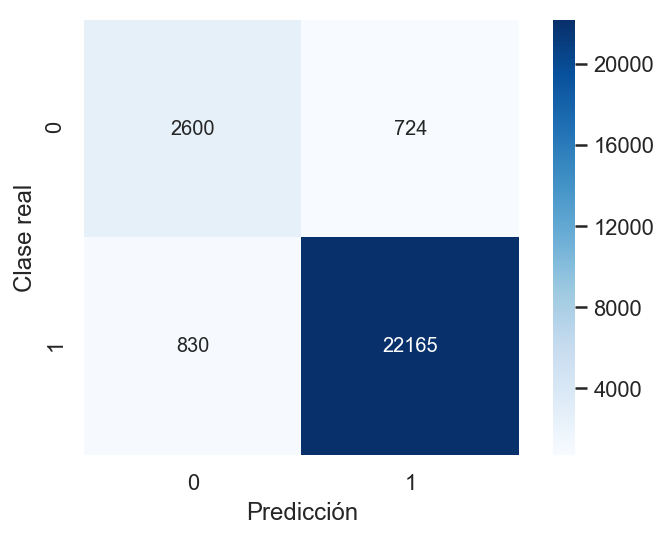

Resultados
Accuracy: 0.941


In [147]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)

In [148]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      3324
           1       0.97      0.96      0.97     22995

    accuracy                           0.94     26319
   macro avg       0.86      0.87      0.87     26319
weighted avg       0.94      0.94      0.94     26319



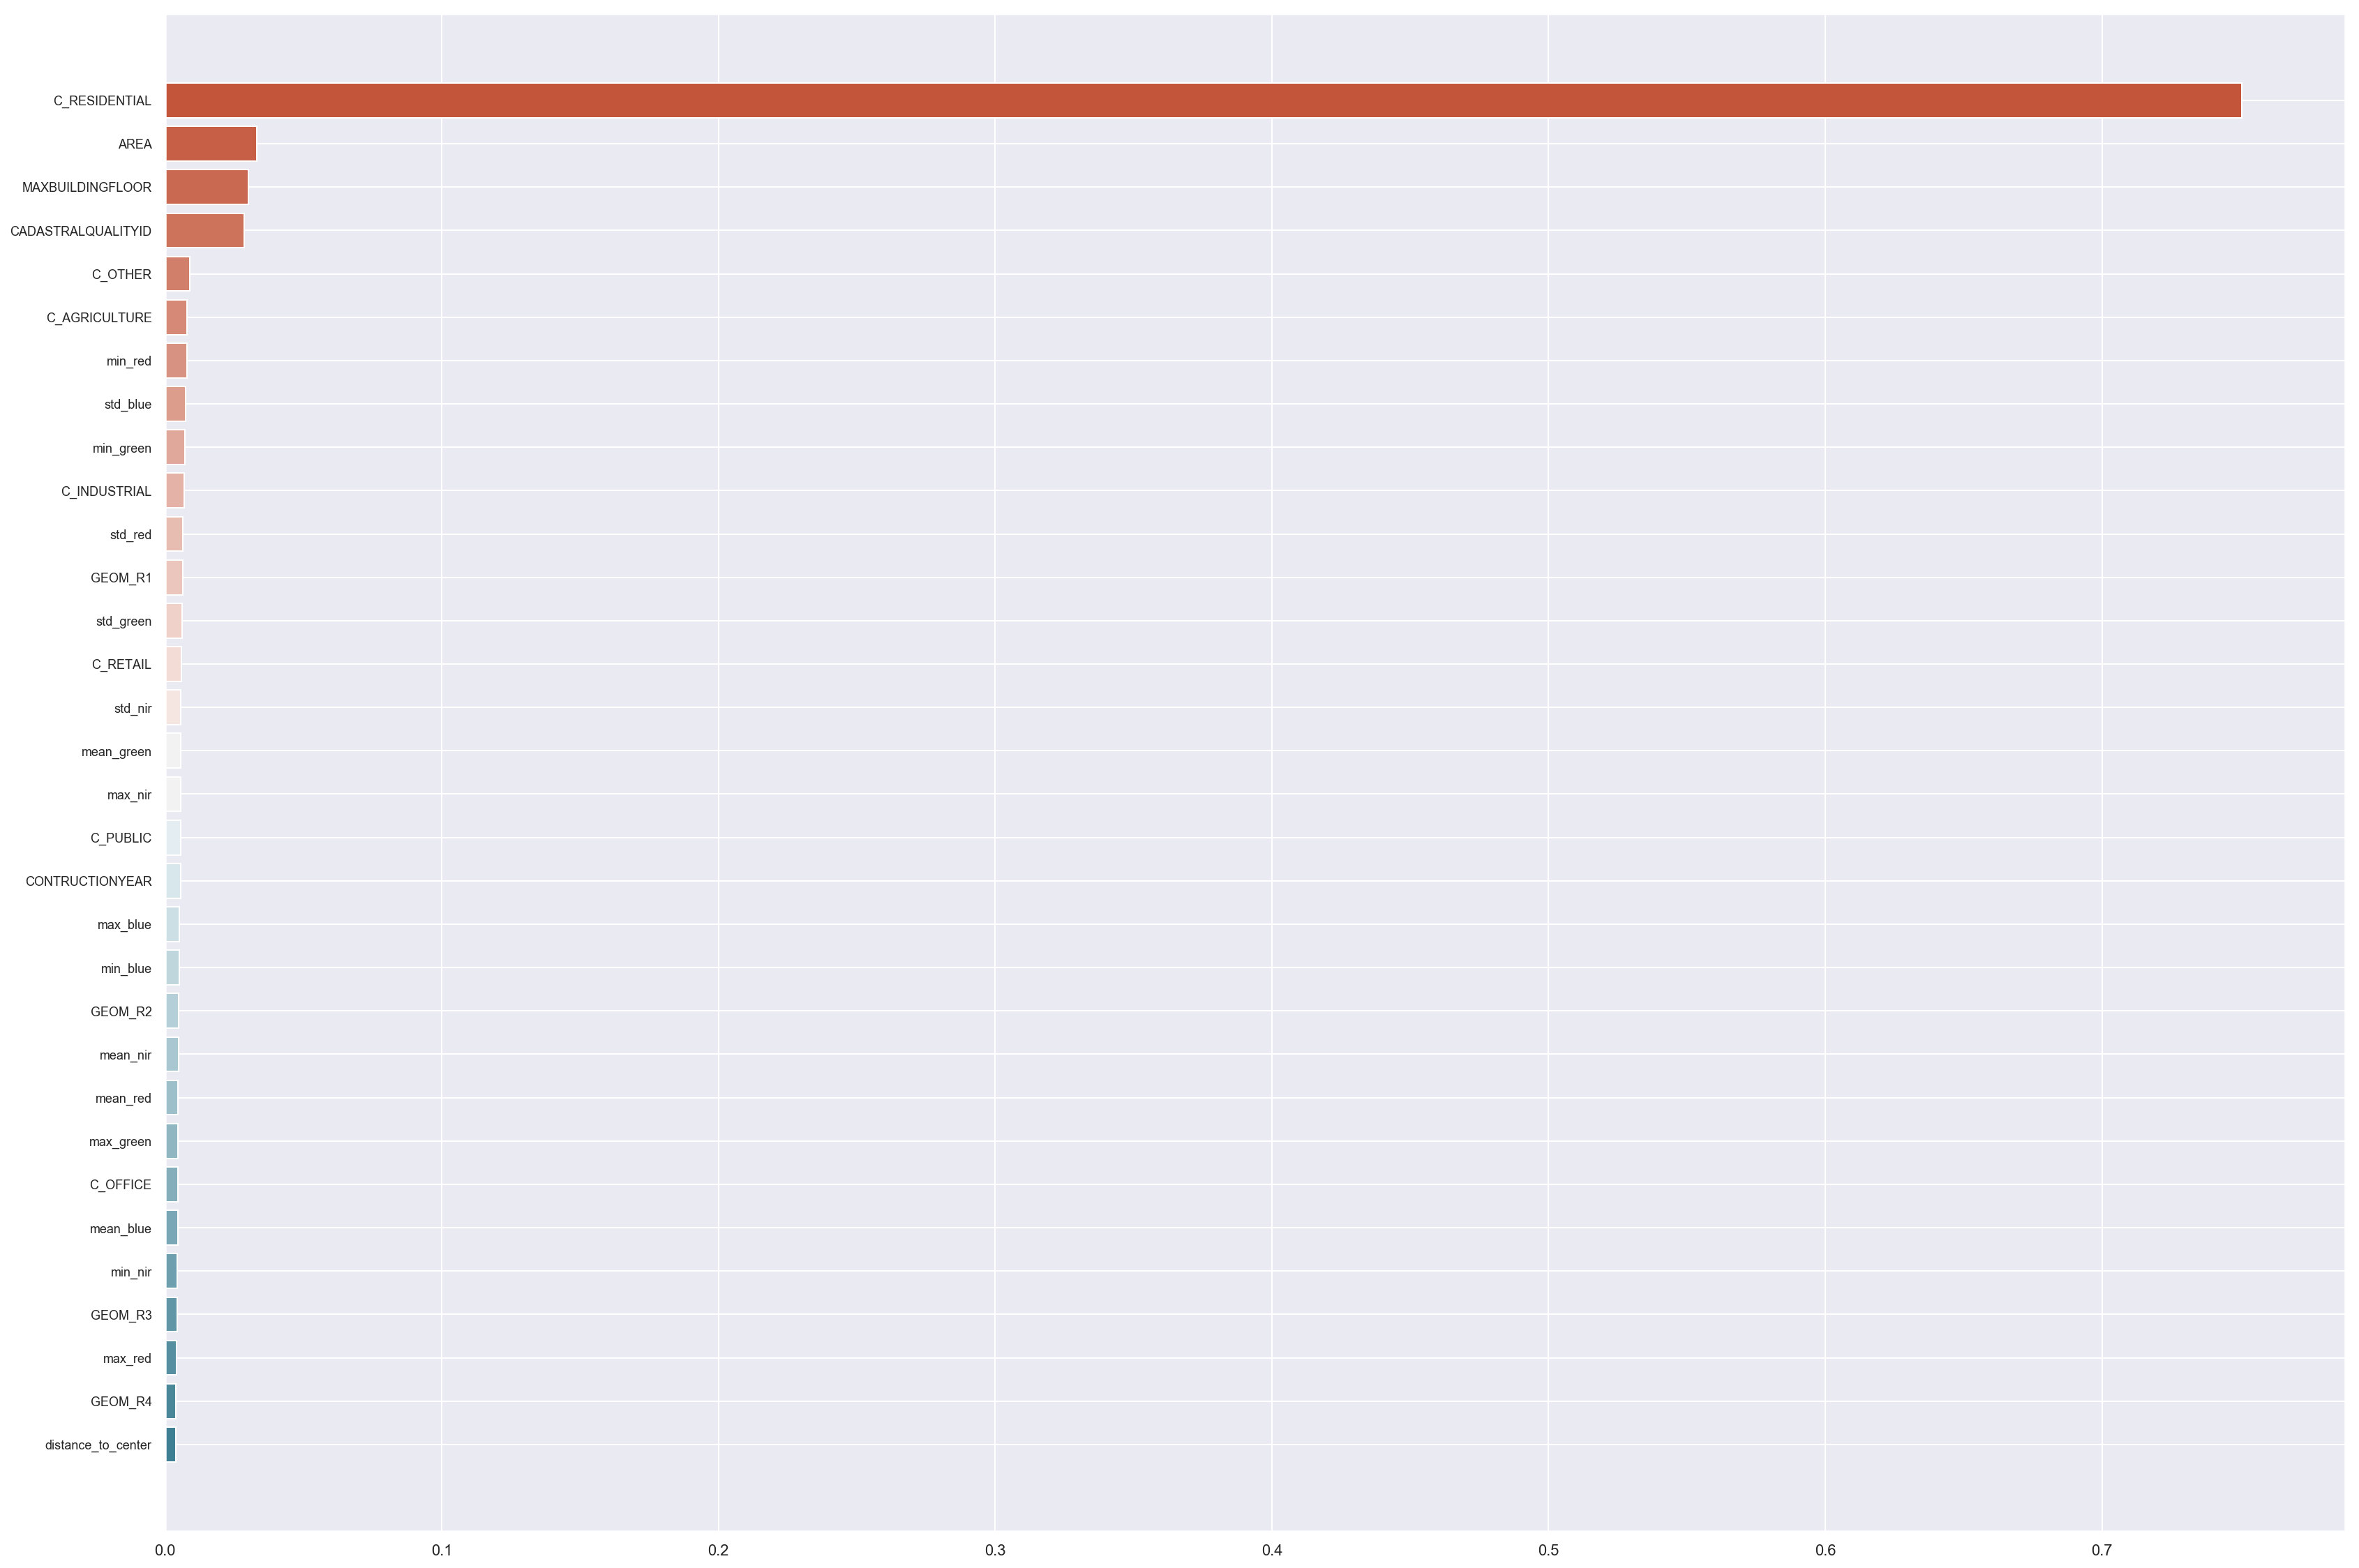

In [149]:
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=len(importances)),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [150]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('binary_xgboost_CCG.model', 'wb'))

---

# MULTIETIQUETA

In [151]:
y_pred_train = minsait_pipe_rfc_p.predict(X_train)

In [152]:
X_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()].drop(columns=['CLASE', 'SUBCLASE']).copy()
y_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()]['CLASE'].copy()

In [153]:
y_multi.value_counts()

INDUSTRIAL     2415
PUBLIC         1522
RESIDENTIAL    1085
RETAIL          959
OFFICE          928
OTHER           707
AGRICULTURE     185
Name: CLASE, dtype: int64

In [154]:
X_multi = df_modelar.drop(columns=['CLASE', 'SUBCLASE']).copy()
y_multi = df_modelar['CLASE'].copy()
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=10)
#smt = SMOTE('not majority', random_state=10)

In [155]:
X_train_multi.columns

Index(['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR',
       'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID', 'distance_to_center',
       'C_AGRICULTURE', 'C_INDUSTRIAL', 'C_OFFICE', 'C_OTHER', 'C_PUBLIC',
       'C_RESIDENTIAL', 'C_RETAIL', 'mean_red', 'mean_green', 'mean_blue',
       'mean_nir', 'max_red', 'max_green', 'max_blue', 'max_nir', 'min_red',
       'min_green', 'min_blue', 'min_nir', 'std_red', 'std_green', 'std_blue',
       'std_nir'],
      dtype='object')

In [169]:
y_train_multi.value_counts()

RESIDENTIAL    53613
INDUSTRIAL      2717
PUBLIC          1746
RETAIL          1226
OFFICE          1092
OTHER            817
AGRICULTURE      198
Name: CLASE, dtype: int64

In [167]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = RandomForestClassifier(random_state=10)
#model = BalancedRandomForestClassifier(random_state=10, sampling_strategy='majority')

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
#parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_minsait_trans),('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train_multi, y_train_multi)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

model_multilabel = GS.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.7s remaining:    0.0s


KeyboardInterrupt: 

In [162]:
y_pred_multi = model_multilabel.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_multi))

              precision    recall  f1-score   support

 AGRICULTURE       0.63      0.78      0.70        76
  INDUSTRIAL       0.40      0.94      0.56      1096
      OFFICE       0.27      0.76      0.40       462
       OTHER       0.25      0.81      0.38       315
      PUBLIC       0.28      0.91      0.43       784
 RESIDENTIAL       1.00      0.74      0.85     23034
      RETAIL       0.24      0.83      0.38       552

    accuracy                           0.75     26319
   macro avg       0.44      0.82      0.53     26319
weighted avg       0.91      0.75      0.80     26319



In [163]:
print(confusion_matrix(y_test_multi, y_pred_multi))

[[   59    16     0     0     1     0     0]
 [    0  1025    17     2    30     0    22]
 [    0    63   350     2    43     0     4]
 [    0    27     2   255    23     0     8]
 [    0    37    15     5   710     0    17]
 [   32  1363   876   753  1706 16933  1371]
 [    2    43    25     3    21     0   458]]


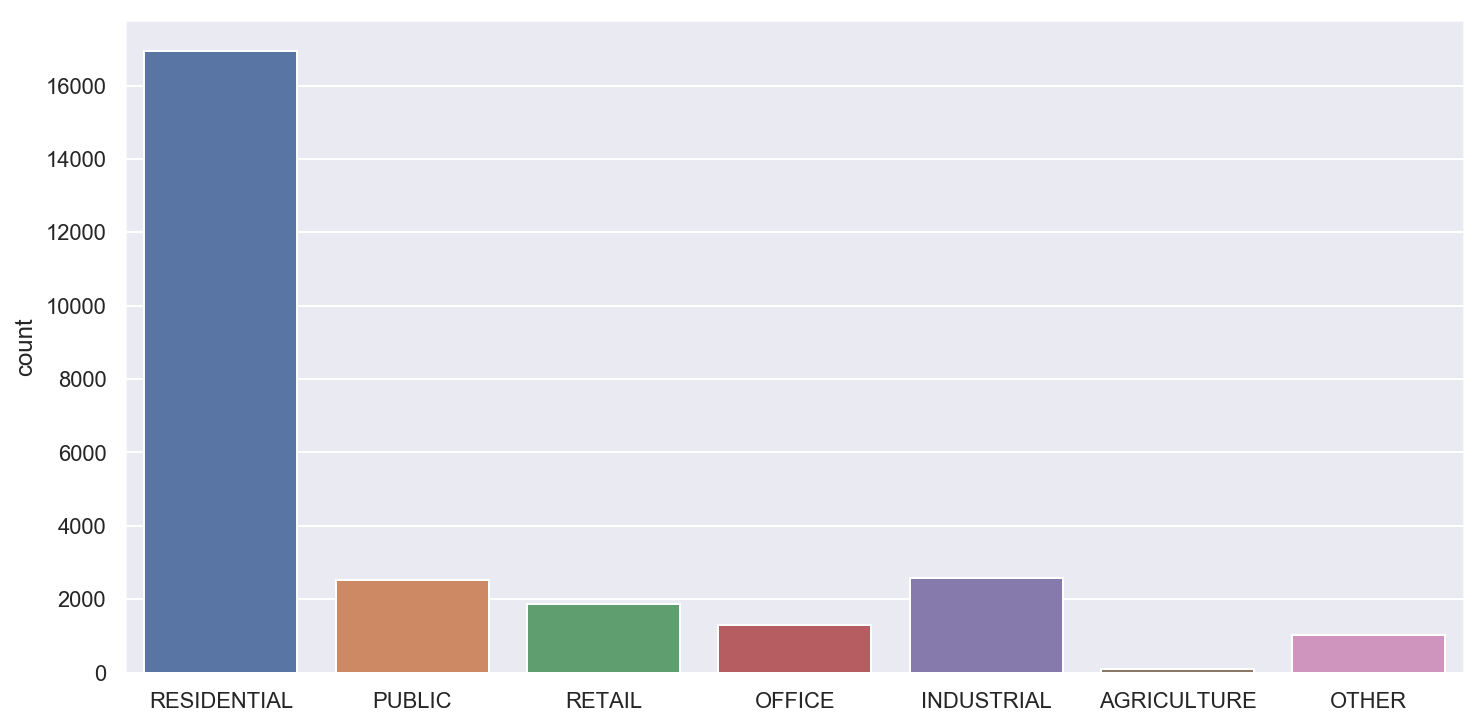

In [164]:
plt.figure(figsize=(12,6))
sns.countplot(y_pred_multi, order=list_class_order);

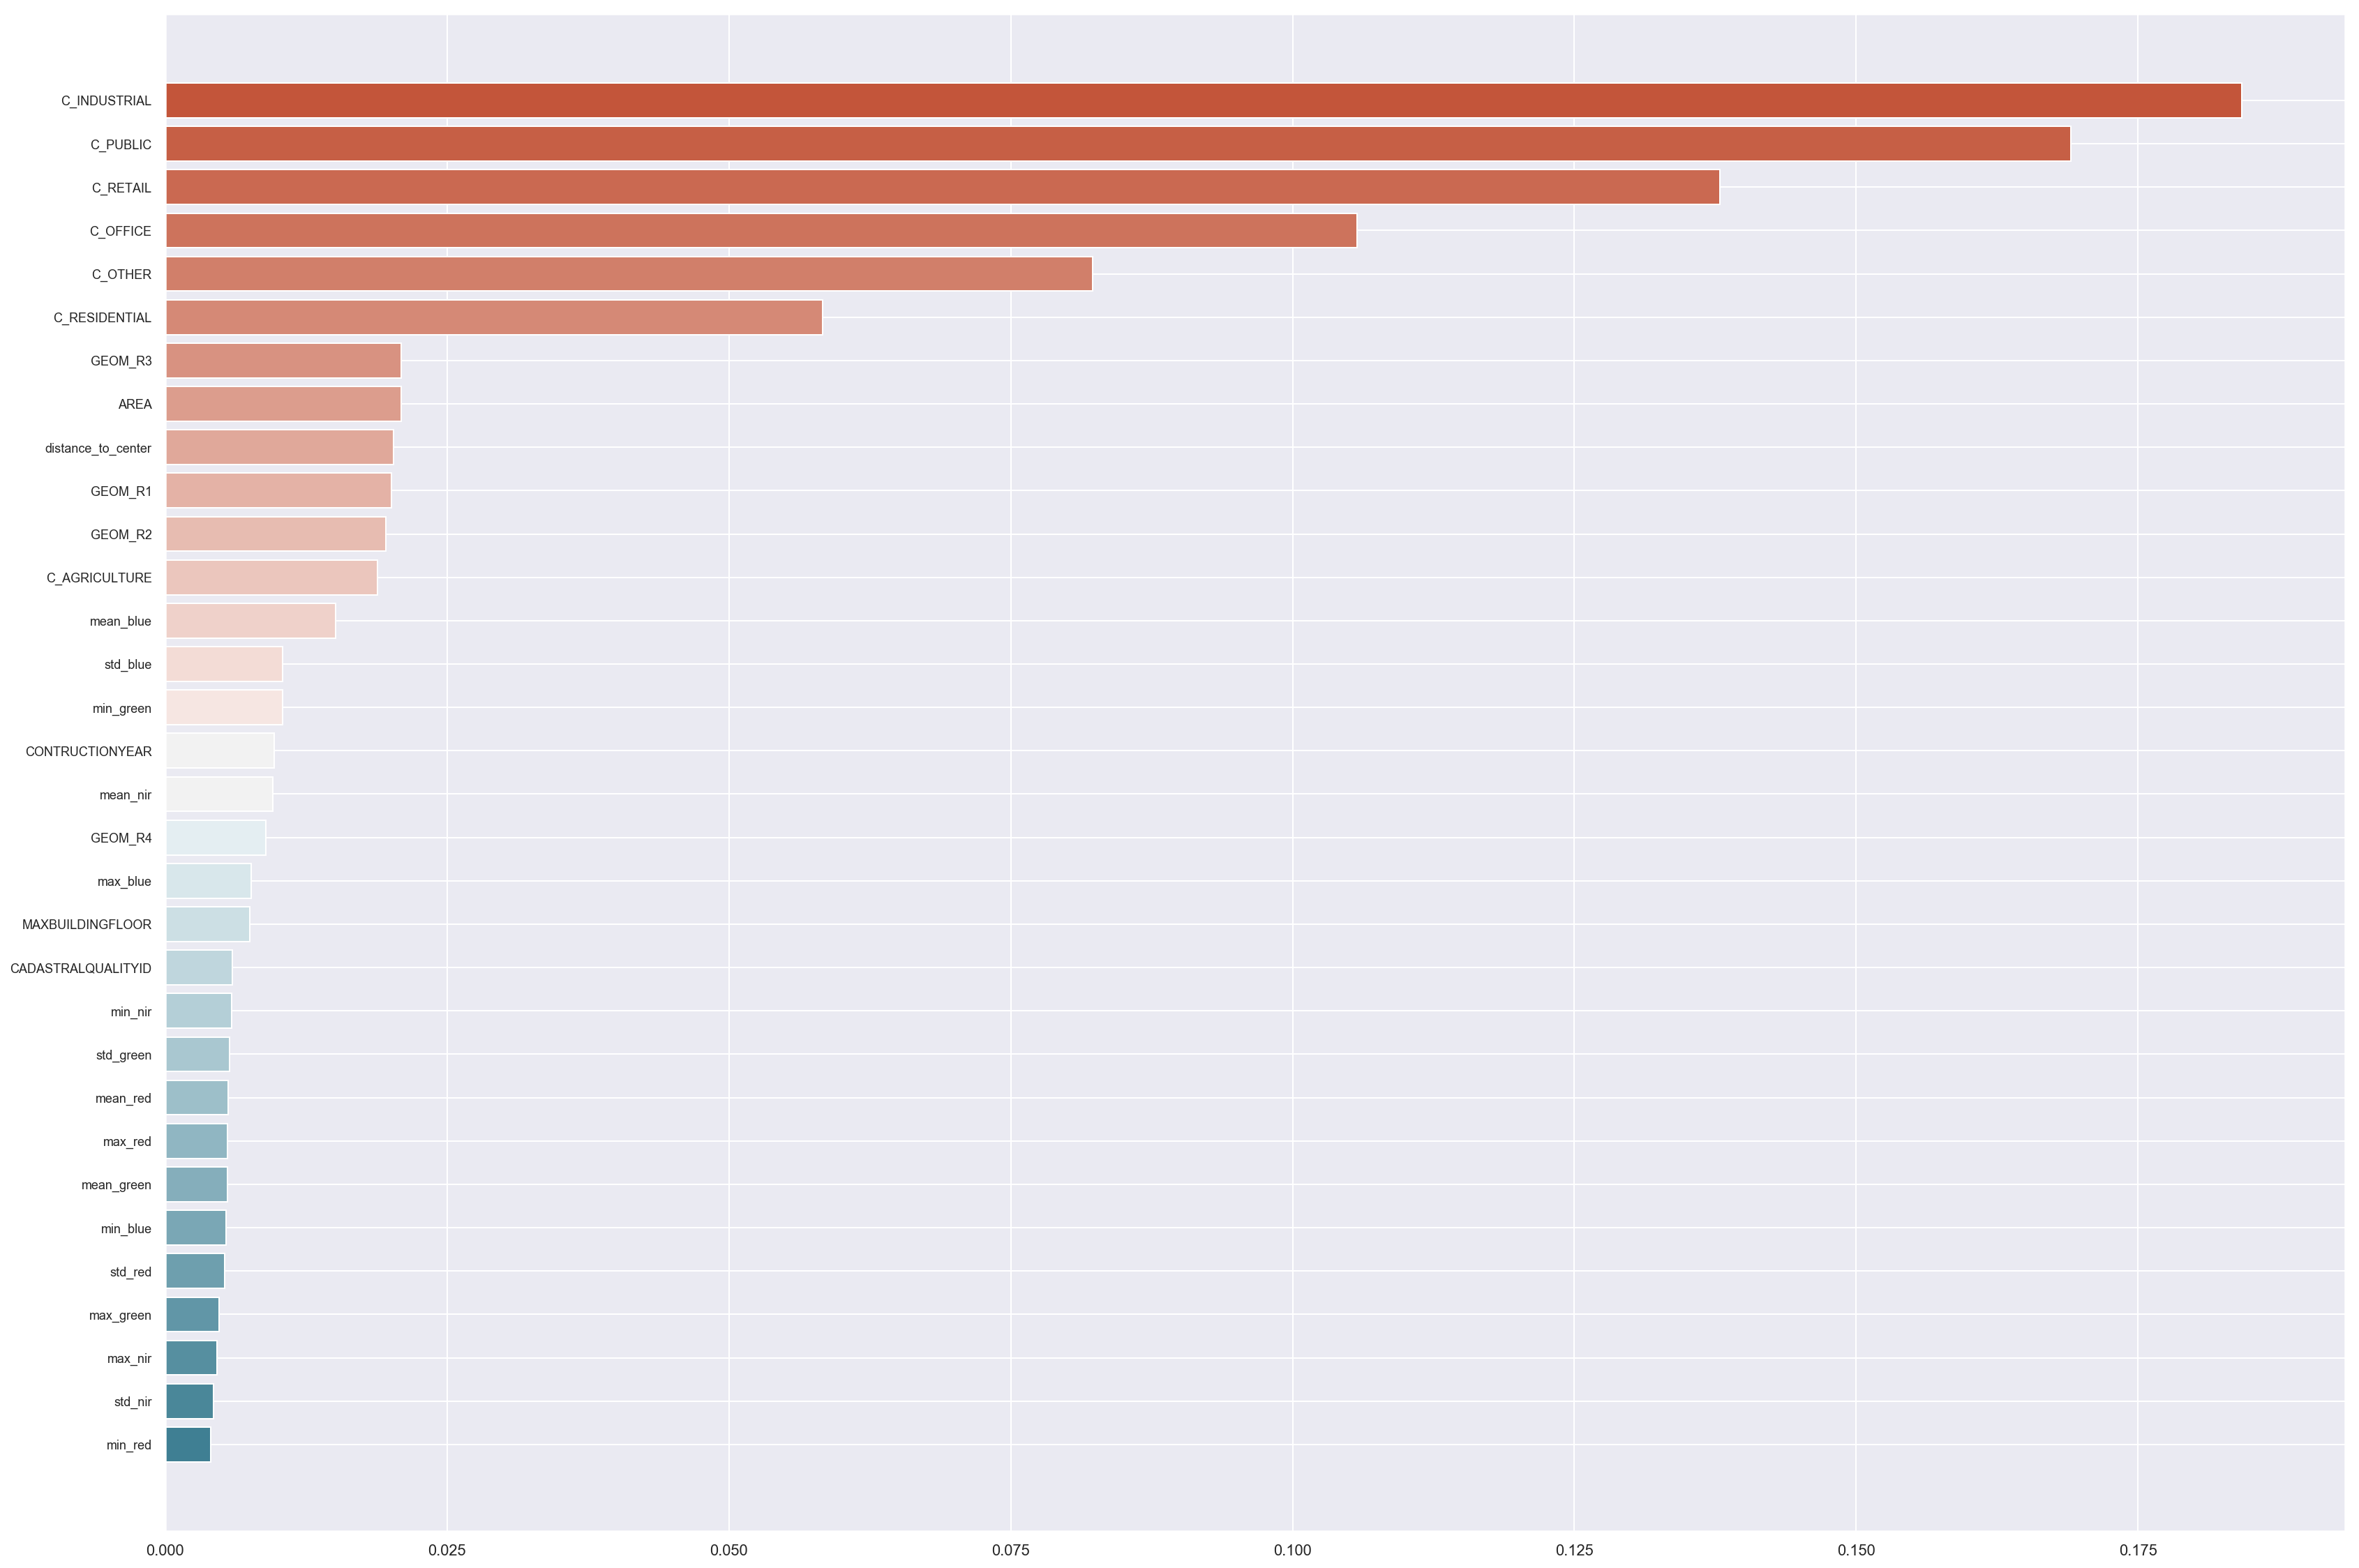

In [165]:
importances = model_multilabel['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=len(importances)),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [166]:
import pickle
pickle.dump(model_multilabel, open('multilabel_rfc_CCG.model', 'wb'))